# Playground to implement W&B as well as start hyperparameter-tuning

# WanDB

In [1]:
#%pip install wandb

In [1]:
import subprocess
import wandb
from wandb.keras import WandbCallback
import tensorflow as tf
import os

In [2]:
subprocess.call(['wandb', 'login', '4e8d3dcb1584ad129b3b49ccc34f65b20116ae54'])

0

In [3]:
wandb.init(project='embed_visualisation')

wandb: Currently logged in as: nkopp (team-bioinf). Use `wandb login --relogin` to force relogin


## Setup

In [ ]:
#%pip install seaborn

In [4]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import wandb
from wandb.keras import WandbCallback
import keras

In [5]:
train_datapath = ["data/"+file for file in os.listdir('data') if file.endswith(".parquet")][0]
batch_size = 32

# Dataset batches + split

In [6]:
import re

def one_hot_precursor(int_value, charges=[1,2,3,4,5,6]):
    """
    One-hot encodes the precursor charge
    :param df: dataframe
    :param max_charge_included: int
    :return: dataframe
    """
    one_hot = [1 if x == int_value else 0 for x in charges]

    return one_hot

In [7]:
file_list = ["data/"+file for file in os.listdir('data') if file.endswith('.parquet')]
print(file_list[0])

data/Thermo_SRM_Pool_meta_data.parquet


### import parquet files, drop all columns we dont need for training, one-hot encode precursor charge, translate sequence

In [8]:
batches_parquet = dict()
counter = 0
for file in file_list:
    df = pd.read_parquet(file, engine='fastparquet')
    # drop all columns we dont need for training
    for column in df.columns:
        if column not in ["modified_sequence","precursor_intensity", "precursor_charge"]:
            df.drop(column, axis=1, inplace=True)
    charge_ranges = [1, 2, 3, 4, 5, 6] # TODO SET RANGES
    df = df[df["precursor_charge"].isin(charge_ranges)] # remove 7+ charge states // only take charge states 2,3,4
    df = df.dropna(subset=['precursor_intensity']) # drop rows with no precursor intensity
    batches_parquet[file] = df
    counter += 1
    #if counter > 1:
    #    break # TODO REMOVE BREAK FOR FIRST FILE IN LIST

In [9]:
vocabulary = []
vocabulary+=list('XACDEFGHIKLMNPQRSTVWY')
max_len_seq = 0

for df in batches_parquet.values():
    if max_len_seq < df['modified_sequence'].str.len().max():
        max_len_seq = df['modified_sequence'].str.len().max()
    annotations = re.findall(r'(\w\[UNIMOD:\d+\])', ' '.join(df['modified_sequence']))
    #annotations = re.findall(r'[A-Z]\[[^\]]*\]|.', ' '.join(df['modified_sequence']))
    for item in annotations:
        if item not in vocabulary:
                vocabulary.append(item)

In [10]:
print(vocabulary)
voc_len = len(vocabulary)
voc_len

['X', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'C[UNIMOD:4]', 'M[UNIMOD:35]']


23

In [11]:
num_classes = len(charge_ranges)
class_names = charge_ranges

In [12]:
batches_parquet[file_list[0]].head()

,modified_sequence,precursor_charge,precursor_intensity
0,LPGSLETYVEQEQGENANDR,2,29525630.0
1,HGSLQEYLQNDTGSK,2,13188580.0
2,VEEEEEINSELTAR,2,20663460.0
3,LPGSLETYVEQEQGENANDR,2,19884630.0
4,NSSTAEINETTTSSTDFLAR,2,12804420.0


In [14]:
file_list

['data/Thermo_SRM_Pool_meta_data.parquet',
 'data/TUM_aspn_meta_data.parquet',
 'data/TUM_first_pool_meta_data.parquet',
 'data/TUM_HLA2_meta_data.parquet',
 'data/TUM_HLA_meta_data.parquet',
 'data/TUM_isoform_meta_data.parquet',
 'data/TUM_lysn_meta_data.parquet',
 'data/TUM_missing_first_meta_data.parquet',
 'data/TUM_proteo_TMT_meta_data.parquet',
 'data/TUM_second_addon_meta_data.parquet',
 'data/TUM_second_pool_meta_data.parquet',
 'data/TUM_third_pool_meta_data.parquet']

In [15]:
batches_parquet[file_list[0]]["precursor_charge"].value_counts()

2    4331294
3    1523398
4     115577
5       2723
1       1022
6        143
Name: precursor_charge, dtype: int64

# Normalisieren:

In [13]:
def normalize_for_most_abundant(df_charge_list, df_intensity_list):
    # Get the index of the most abundant precursor intensity
    charge_dict = dict()
    for index, i in enumerate(df_charge_list):
        charge_dict[i] = []
        charge_dict[i].append(df_intensity_list[index])

    # Normalize the precursor intensity based on the most abundant precursor intensity
    for key, value in charge_dict.items():
        if len(value) > 1:
         charge_dict[key] = sum(value) - min(value) / (max(value) - min(value))

    # convert list of one float to float values
    charge_dict = {key: value[0] for key, value in charge_dict.items()}

    return charge_dict

In [14]:
def get_most_abundant(df_charge_list, df_intensity_list, distributions=False):
    # Get the index of the most abundant precursor intensity
    charge_dict = dict()
    for index, i in enumerate(df_charge_list):
        if i not in charge_dict:
            charge_dict[i] = df_intensity_list[index]
        else:
            charge_dict[i] += df_intensity_list[index]
    if distributions:
        #print(charge_dict)
        return charge_dict
    else:
        return max(charge_dict, key=charge_dict.get)


In [15]:
# load all parquets into df
df_dict = dict()
for file in file_list:
    df_dict[file] = batches_parquet[file].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()

C:\Users\micro\AppData\Local\Temp\ipykernel_12520\2139590162.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_dict[file] = batches_parquet[file].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()
C:\Users\micro\AppData\Local\Temp\ipykernel_12520\2139590162.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_dict[file] = batches_parquet[file].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()
C:\Users\micro\AppData\Local\Temp\ipykernel_12520\2139590162.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_dict[file] = batches_parquet[file].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()
C:\Users\micro\A

# init merged_df

In [16]:
merged_df = pd.concat(list(df_dict.values())).groupby("modified_sequence")["precursor_charge", "precursor_intensity"].sum().reset_index()

C:\Users\micro\AppData\Local\Temp\ipykernel_12520\1215419649.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  merged_df = pd.concat(list(df_dict.values())).groupby("modified_sequence")["precursor_charge", "precursor_intensity"].sum().reset_index()


In [17]:
merged_df['seq_len_prepadding'] = merged_df['modified_sequence'].apply(lambda x: len(x))

In [18]:
len_counts = merged_df['seq_len_prepadding'].value_counts()
seq_too_long = len_counts[len_counts <= 10]
seq_too_long

87     9
82     8
85     7
89     6
90     5
107    4
97     4
95     4
92     4
83     3
86     3
98     3
91     2
84     2
93     2
88     2
96     2
110    2
105    1
104    1
102    1
94     1
103    1
115    1
99     1
125    1
108    1
Name: seq_len_prepadding, dtype: int64

In [19]:
seq_lengths = merged_df['seq_len_prepadding'].value_counts().index.values, merged_df['seq_len_prepadding'].value_counts().values
seq_too_long = pd.DataFrame()
seq_too_long['seq_len'] = seq_lengths[0][seq_lengths[0] >= 50]
seq_too_long['count'] = seq_lengths[1][seq_lengths[0] >= 50]
seq_too_long

,seq_len,count
0,50,1087
1,51,764
2,52,595
3,53,426
4,56,385
5,57,385
6,55,382
7,58,373
8,54,366
9,59,290


In [20]:
# give smallest seq_len when count <= 100
seq_len_cutoff_df = seq_too_long[seq_too_long['count'] <= 100]
seq_len_cutoff = min(seq_len_cutoff_df['seq_len'])

In [21]:
seq_len_cutoff

64

In [22]:
# reapply max len
max_len_seq = seq_len_cutoff-1

In [23]:
def seq_translator(sequence, dictionary=vocabulary, max_len=max_len_seq, print_result=False, no_padding=False):
    """
    Translates a sequence into a vector of integers
    :param print_result:
    :param max_len:
    :param sequence: string
    :param dictionary: dictionary
    :return: list
    """
    pattern = r'[A-Z]\[[^\]]*\]|.' # regex pattern to match amino acids and modifications
    #pattern = r'(\w\[UNIMOD:\d+\])' # regex pattern to match amino acids and modifications

    result = [match for match in re.findall(pattern, sequence)]

    # Fill the list with "X" characters until it reaches a length of 40
    if not no_padding:
        result += ['X'] * (max_len - len(result))
    if print_result:
        print(result)

    aa_dictionary = dict()
    for index, aa in enumerate(dictionary):
        aa_dictionary[aa] = index

    return [aa_dictionary[aa] for aa in result]

In [24]:
delete_a_row = True
if delete_a_row:
# delete row if seq_len_prepadding larger or equal to seq_len_cutoff
    index_to_delete_seq = merged_df[merged_df['seq_len_prepadding'] >= seq_len_cutoff].index
    merged_df.drop(index_to_delete_seq, inplace=True)

In [25]:
# output all sequences with seq_len_prepadding >= 50
merged_df[merged_df['seq_len_prepadding'] >= seq_len_cutoff]

,modified_sequence,precursor_charge,precursor_intensity,seq_len_prepadding


In [26]:
merged_df['normalized'] = merged_df.apply(lambda x: normalize_for_most_abundant(x["precursor_charge"], x["precursor_intensity"]), axis=1)

In [27]:
merged_df['pre_normalization'] = merged_df.apply(lambda x: get_most_abundant(x["precursor_charge"], x["precursor_intensity"], True), axis=1)

In [28]:
# return key for max value in dict
merged_df['most_abundant_charge'] = merged_df['normalized'].apply(lambda x: max(x, key=x.get))

In [29]:
merged_df["most_abundant_charge_vector"] = merged_df["most_abundant_charge"].apply(one_hot_precursor, args=(charge_ranges,))

In [30]:
merged_df["modified_sequence_vector"] = merged_df["modified_sequence"].apply(seq_translator)

In [31]:
merged_df.head(11)

,modified_sequence,precursor_charge,precursor_intensity,seq_len_prepadding,normalized,pre_normalization,most_abundant_charge,most_abundant_charge_vector,modified_sequence_vector
0,AAAAAAAAAAAAAAAAGLGLGP,"[2, 3, 2, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, ...","[12746190.0, 2009914.0, 12746190.0, 791369.9, ...",22,"{2: 588796.3, 3: 4654280.0, 1: 791369.9}","{2: 1043873837.3, 3: 30130627.0, 1: 1582739.8}",3,"[0, 0, 1, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,AAAAAAAAAAAAAAAASAGGK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[5944787.0, 5944787.0, 8502878.0, 6425294.0, 8...",21,{2: 303307.5},{2: 107202221.5},2,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,AAAAAAAAAAAAAAAGAGAGAK,"[2, 2, 2, 2]","[3067981.0, 3067981.0, 3067981.0, 3067981.0]",22,{2: 3067981.0},{2: 12271924.0},2,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,AAAAAAAAAAAAAAASGFAYPGTSER,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[11913300.0, 11913300.0, 11913300.0, 11913300....",26,"{2: 8093413.0, 3: 1414907.0}","{2: 148659685.0, 3: 4244721.0}",2,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,AAAAAAAAAAAAAAG,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1573785.0, 4638296.0, 7934979.0, 2019978.0, 4...",15,{1: 1124818.0},{1: 546950229.4000001},1,"[1, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, ..."
5,AAAAAAAAAAAAAAGAG,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[853119.3, 4332449.0, 3688977.0, 3469130.0, 33...",17,{1: 679216.3},{1: 52634067.9},1,"[1, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, ..."
6,AAAAAAAAAAAAAAGGLALGLH,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[33516080.0, 33516080.0, 8522070.0, 4549188.0,...",22,{2: 365943.3},{2: 6848110396.300002},2,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, ..."
7,AAAAAAAAAAAAAAVTSGV,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[4576179.0, 3336856.0, 4954145.0, 4317804.0, 3...",19,"{2: 14611910.0, 1: 1211272.0}","{2: 225462597.40000004, 1: 5840742.2}",2,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 18,..."
8,AAAAAAAAAAAAAGAG,"[1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, ...","[1233316.0, 2671238.0, 11414430.0, 13683660.0,...",16,"{1: 1879604.0, 2: 2586197.0}","{1: 349665943.5, 2: 228379326.3}",2,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, ..."
9,AAAAAAAAAAAAAK,"[1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, ...","[2540360.0, 31115000.0, 31115000.0, 70371250.0...",14,"{1: 8372130.0, 2: 15308280.0}","{1: 99493666.2, 2: 6574531120.0}",2,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 0, ..."


In [32]:
len(merged_df)

830820

In [33]:
merged_df["most_abundant_charge"].value_counts()

2    452544
3    259972
4     65966
1     41352
5      9069
6      1917
Name: most_abundant_charge, dtype: int64

In [ ]:
#get the

In [34]:
print(file_list[0])
look_up_df = batches_parquet[file_list[0]].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()
len(look_up_df)

data/Thermo_SRM_Pool_meta_data.parquet


C:\Users\micro\AppData\Local\Temp\ipykernel_12520\365009680.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  look_up_df = batches_parquet[file_list[0]].groupby("modified_sequence")["precursor_charge", "precursor_intensity"].agg(list).reset_index()


70445

# Dataset preprocessing: Conv2d

In [38]:
# proof of concept
# we have a sequence ABC with:
list_a = [1,2,1,2,1,2,1,2,1,2] # charge states for "ABC" sequence with multiple appearances
list_b = [111,21,311,41,51,611111,71,81,91111111,1011] # intensities for "ABC" sequence in each charge state
print("most abundant: ", get_most_abundant(list_a, list_b, True))

most abundant:  {1: 91111655, 2: 612265}


In [39]:
main_ds = np.array(merged_df["modified_sequence_vector"]) # to list
main_ds_labels = np.array(merged_df['most_abundant_charge_vector'])

In [40]:
# Create an instance of StratifiedShuffleSplit
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

# Perform the split train+val and test
trainval_indicies, test_indicies = next(sss1.split(main_ds, main_ds_labels))

trainval_ds, trainval_labels = main_ds[trainval_indicies], main_ds_labels[trainval_indicies]
test_ds, test_labels = main_ds[test_indicies], main_ds_labels[test_indicies]

In [125]:
# Perform the split train and val
train_indicies, val_indicies = next(sss2.split(trainval_ds, trainval_labels))

train_ds, train_labels = trainval_ds[train_indicies], trainval_labels[train_indicies]
val_ds, val_labels = trainval_ds[val_indicies], trainval_labels[val_indicies]


charges = [1,2,3,4,5,6] # TODO SELECT CLASSES
num_classes = len(charges)

### Conv2d Model

In [50]:
train_ds = [np.reshape(np.array(x), (1, max_len_seq, 1)) for x in train_ds_embed]
val_ds = [np.reshape(np.array(x), (1, max_len_seq, 1)) for x in val_ds_embed]
test_ds = [np.reshape(np.array(x), (1, max_len_seq, 1)) for x in test_ds_embed]

In [71]:
def de_seq_translator(sequence_integers):
    vocab = ['X', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'C[UNIMOD:4]', 'M[UNIMOD:35]']

    vocab_dict = dict()
    for char in vocab:
        vocab_dict[vocab.index(char)] = char
        
    
    
    de_translated = [vocab_dict[i] for i in sequence_integers]
    
    word = ' ,'.join(de_translated).lstrip("[").rstrip("]").replace("'",'').replace(" ,",'')
    while word[-1] == 'X':
        word = word[:-1]
    print(word)
    

In [72]:
de_seq_translator(train_ds_embed[0].numpy())

VVSAGPWSSEKAEMNILEINETLR


In [73]:
plt.style.use({'figure.facecolor':'white'})

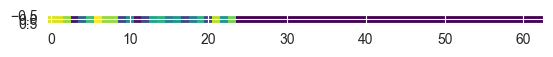

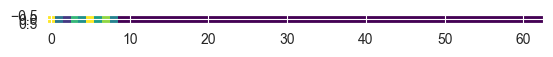

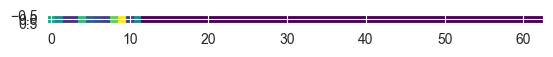

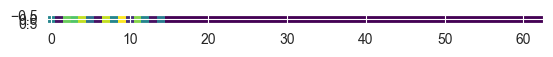

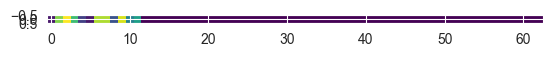

In [74]:
from matplotlib import pyplot as plt
for i in range(5):
    plt.style.use({'figure.facecolor':'white'})
    plt.imshow(train_ds[i], interpolation='nearest', cmap='viridis') # TODO CUSTOM COLORS FOR AA
    plt.show()

In [75]:
train_ds = tf.convert_to_tensor(train_ds)
val_ds = tf.convert_to_tensor(val_ds)

In [76]:
from keras import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Input, concatenate, Rescaling
# define two sets of inputs
inputA = Input(shape=train_ds.shape[1:])
# the first branch operates on the first input
x = Model(inputs=inputA, outputs=inputA)
# the second branch operates on the second input
y = Rescaling(scale=1./100)(inputA) # for dictionary of 2000 words (X = 0, aa 1-20 in 100 steps)
#y = Embedding(input_dim=2000, output_dim=3, input_length=50)(inputB)
y = Conv2D(filters=128, kernel_size=(1,3), strides=1, activation="relu", padding='same')(y)
#y = MaxPooling2D(pool_size=(1,2), padding='same')(y)
#y = Conv2D(filters=128, kernel_size=(1,3), strides=1, activation="relu", padding='same')(y)
#y = MaxPooling2D(pool_size=(1,2), padding='same')(y)
y = Flatten()(y)
y = Dense(210, activation="relu")(y)
# combine the output of the two branches
#z = Flatten()(combined)
z = Dense(num_classes, activation="softmax")(y)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input], outputs=z)

In [77]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 63, 1)]        0         
                                                                 
 rescaling (Rescaling)       (None, 1, 63, 1)          0         
                                                                 
 conv2d (Conv2D)             (None, 1, 63, 128)        512       
                                                                 
 flatten (Flatten)           (None, 8064)              0         
                                                                 
 dense (Dense)               (None, 210)               1693650   
                                                                 
 dense_1 (Dense)             (None, 6)                 1266      
                                                                 
Total params: 1,695,428
Trainable params: 1,695,428
Non-tra

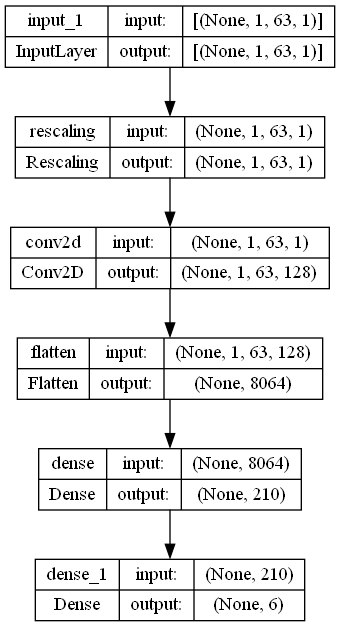

In [78]:
# plot model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [85]:
# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['categorical_accuracy'])

In [86]:
checkpoint_callback = ModelCheckpoint('precursor_charge_prediction_model_v1/cce_wo7_allSequences.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
#steps_per_epoch = train_ds_b.shape[0] // 256

In [87]:
# Train the model
# X_train, X_test, y_train, y_test
history = model.fit(train_ds, train_labels_embed, epochs=30, batch_size=4096, validation_data=(val_ds, val_labels_embed), callbacks=[WandbCallback()]) #WandbCallback()

Epoch 1/30
146/147 [============================>.] - ETA: 0s - loss: 0.8922 - categorical_accuracy: 0.6065

INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best)... Done. 0.1s


147/147 [==============================] - 25s 167ms/step - loss: 0.8922 - categorical_accuracy: 0.6065 - val_loss: 0.8933 - val_categorical_accuracy: 0.6049
Epoch 2/30
146/147 [============================>.] - ETA: 0s - loss: 0.8913 - categorical_accuracy: 0.6069

INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best)... Done. 0.1s


147/147 [==============================] - 25s 168ms/step - loss: 0.8913 - categorical_accuracy: 0.6069 - val_loss: 0.8921 - val_categorical_accuracy: 0.6057
Epoch 3/30
146/147 [============================>.] - ETA: 0s - loss: 0.8904 - categorical_accuracy: 0.6070

INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best)... Done. 0.1s


147/147 [==============================] - 25s 170ms/step - loss: 0.8904 - categorical_accuracy: 0.6070 - val_loss: 0.8915 - val_categorical_accuracy: 0.6059
Epoch 4/30
147/147 [==============================] - 26s 177ms/step - loss: 0.8898 - categorical_accuracy: 0.6069 - val_loss: 0.8915 - val_categorical_accuracy: 0.6051
Epoch 5/30
146/147 [============================>.] - ETA: 0s - loss: 0.8891 - categorical_accuracy: 0.6074

INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best)... Done. 0.1s


147/147 [==============================] - 27s 182ms/step - loss: 0.8891 - categorical_accuracy: 0.6074 - val_loss: 0.8898 - val_categorical_accuracy: 0.6063
Epoch 6/30
147/147 [==============================] - 26s 176ms/step - loss: 0.8887 - categorical_accuracy: 0.6072 - val_loss: 0.8905 - val_categorical_accuracy: 0.6064
Epoch 7/30
147/147 [==============================] - 26s 180ms/step - loss: 0.8882 - categorical_accuracy: 0.6073 - val_loss: 0.8900 - val_categorical_accuracy: 0.6055
Epoch 8/30
146/147 [============================>.] - ETA: 0s - loss: 0.8876 - categorical_accuracy: 0.6074

INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best)... Done. 0.1s


147/147 [==============================] - 27s 180ms/step - loss: 0.8877 - categorical_accuracy: 0.6074 - val_loss: 0.8887 - val_categorical_accuracy: 0.6065
Epoch 9/30
146/147 [============================>.] - ETA: 0s - loss: 0.8873 - categorical_accuracy: 0.6075

INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best)... Done. 0.1s


147/147 [==============================] - 25s 168ms/step - loss: 0.8873 - categorical_accuracy: 0.6075 - val_loss: 0.8879 - val_categorical_accuracy: 0.6066
Epoch 10/30
146/147 [============================>.] - ETA: 0s - loss: 0.8867 - categorical_accuracy: 0.6076

INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best)... Done. 0.1s


147/147 [==============================] - 25s 169ms/step - loss: 0.8867 - categorical_accuracy: 0.6076 - val_loss: 0.8877 - val_categorical_accuracy: 0.6068
Epoch 11/30
147/147 [==============================] - 25s 172ms/step - loss: 0.8863 - categorical_accuracy: 0.6077 - val_loss: 0.8881 - val_categorical_accuracy: 0.6067
Epoch 12/30
146/147 [============================>.] - ETA: 0s - loss: 0.8861 - categorical_accuracy: 0.6078

INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best)... Done. 0.1s


147/147 [==============================] - 26s 176ms/step - loss: 0.8861 - categorical_accuracy: 0.6078 - val_loss: 0.8872 - val_categorical_accuracy: 0.6060
Epoch 13/30
146/147 [============================>.] - ETA: 0s - loss: 0.8859 - categorical_accuracy: 0.6075

INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best)... Done. 0.1s


147/147 [==============================] - 25s 168ms/step - loss: 0.8859 - categorical_accuracy: 0.6075 - val_loss: 0.8864 - val_categorical_accuracy: 0.6071
Epoch 14/30
147/147 [==============================] - 23s 159ms/step - loss: 0.8854 - categorical_accuracy: 0.6078 - val_loss: 0.8875 - val_categorical_accuracy: 0.6064
Epoch 15/30
147/147 [==============================] - 23s 155ms/step - loss: 0.8850 - categorical_accuracy: 0.6082 - val_loss: 0.8872 - val_categorical_accuracy: 0.6056
Epoch 16/30
146/147 [============================>.] - ETA: 0s - loss: 0.8846 - categorical_accuracy: 0.6081

INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best)... Done. 0.1s


147/147 [==============================] - 24s 161ms/step - loss: 0.8846 - categorical_accuracy: 0.6081 - val_loss: 0.8863 - val_categorical_accuracy: 0.6066
Epoch 17/30
146/147 [============================>.] - ETA: 0s - loss: 0.8844 - categorical_accuracy: 0.6080

INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best)... Done. 0.1s


147/147 [==============================] - 23s 157ms/step - loss: 0.8844 - categorical_accuracy: 0.6080 - val_loss: 0.8851 - val_categorical_accuracy: 0.6074
Epoch 18/30
147/147 [==============================] - 22s 153ms/step - loss: 0.8840 - categorical_accuracy: 0.6082 - val_loss: 0.8858 - val_categorical_accuracy: 0.6068
Epoch 19/30
146/147 [============================>.] - ETA: 0s - loss: 0.8839 - categorical_accuracy: 0.6080

INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best)... Done. 0.1s


147/147 [==============================] - 23s 157ms/step - loss: 0.8839 - categorical_accuracy: 0.6080 - val_loss: 0.8847 - val_categorical_accuracy: 0.6074
Epoch 20/30
147/147 [==============================] - 22s 153ms/step - loss: 0.8835 - categorical_accuracy: 0.6085 - val_loss: 0.8867 - val_categorical_accuracy: 0.6064
Epoch 21/30
146/147 [============================>.] - ETA: 0s - loss: 0.8834 - categorical_accuracy: 0.6080

INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best)... Done. 0.1s


147/147 [==============================] - 24s 161ms/step - loss: 0.8834 - categorical_accuracy: 0.6080 - val_loss: 0.8845 - val_categorical_accuracy: 0.6078
Epoch 22/30
146/147 [============================>.] - ETA: 0s - loss: 0.8830 - categorical_accuracy: 0.6084

INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best)... Done. 0.1s


147/147 [==============================] - 24s 164ms/step - loss: 0.8830 - categorical_accuracy: 0.6084 - val_loss: 0.8845 - val_categorical_accuracy: 0.6073
Epoch 23/30
146/147 [============================>.] - ETA: 0s - loss: 0.8829 - categorical_accuracy: 0.6086

INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best)... Done. 0.1s


147/147 [==============================] - 27s 186ms/step - loss: 0.8829 - categorical_accuracy: 0.6086 - val_loss: 0.8839 - val_categorical_accuracy: 0.6080
Epoch 24/30
147/147 [==============================] - 26s 175ms/step - loss: 0.8828 - categorical_accuracy: 0.6086 - val_loss: 0.8840 - val_categorical_accuracy: 0.6072
Epoch 25/30
147/147 [==============================] - 26s 176ms/step - loss: 0.8823 - categorical_accuracy: 0.6087 - val_loss: 0.8846 - val_categorical_accuracy: 0.6062
Epoch 26/30
146/147 [============================>.] - ETA: 0s - loss: 0.8822 - categorical_accuracy: 0.6089

INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best)... Done. 0.1s


147/147 [==============================] - 26s 176ms/step - loss: 0.8822 - categorical_accuracy: 0.6089 - val_loss: 0.8832 - val_categorical_accuracy: 0.6077
Epoch 27/30
146/147 [============================>.] - ETA: 0s - loss: 0.8818 - categorical_accuracy: 0.6089

INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best)... Done. 0.1s


147/147 [==============================] - 26s 176ms/step - loss: 0.8819 - categorical_accuracy: 0.6089 - val_loss: 0.8829 - val_categorical_accuracy: 0.6085
Epoch 28/30
147/147 [==============================] - 25s 169ms/step - loss: 0.8820 - categorical_accuracy: 0.6087 - val_loss: 0.8834 - val_categorical_accuracy: 0.6074
Epoch 29/30
147/147 [==============================] - 24s 162ms/step - loss: 0.8818 - categorical_accuracy: 0.6089 - val_loss: 0.8844 - val_categorical_accuracy: 0.6069
Epoch 30/30
146/147 [============================>.] - ETA: 0s - loss: 0.8817 - categorical_accuracy: 0.6086

INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best\assets
wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230830_095952-yqcfpp7l\files\model-best)... Done. 0.1s


147/147 [==============================] - 26s 176ms/step - loss: 0.8817 - categorical_accuracy: 0.6086 - val_loss: 0.8827 - val_categorical_accuracy: 0.6077


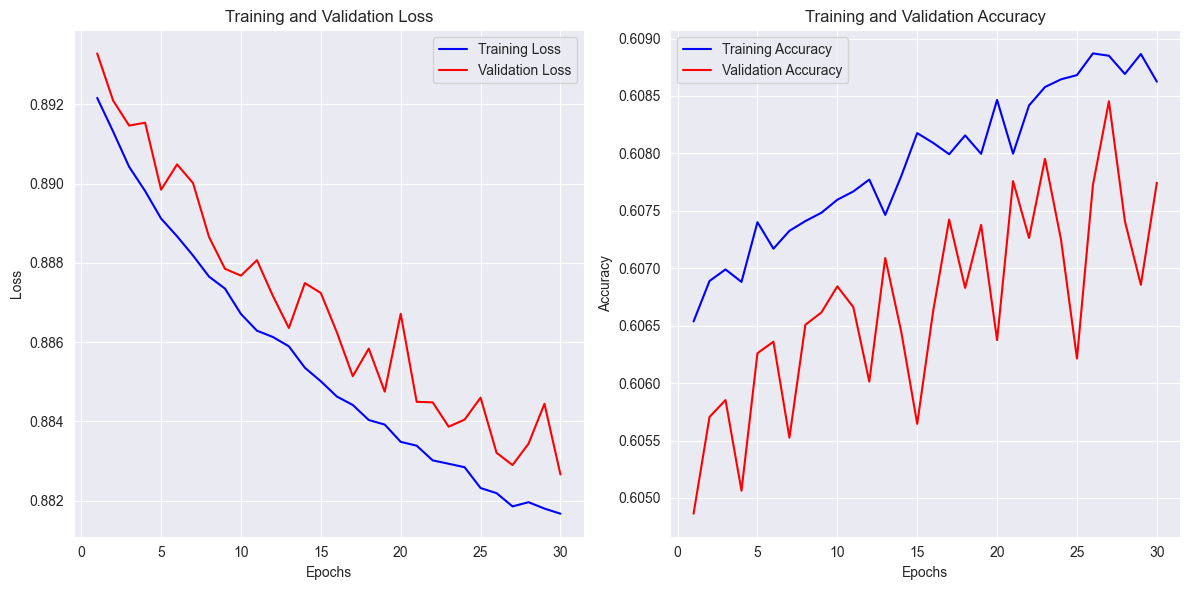

In [90]:
# Access the loss, validation loss, and accuracy from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['categorical_accuracy']
val_accuracy = history.history['val_categorical_accuracy']

# Plot the loss, validation loss, and accuracy curves
epochs = range(1, len(loss) + 1)

# Create subplots
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot loss and validation loss
ax1.plot(epochs, loss, 'b', label='Training Loss')
ax1.plot(epochs, val_loss, 'r', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot accuracy and validation accuracy
ax2.plot(epochs, accuracy, 'b', label='Training Accuracy')
ax2.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
model.save('precursor_charge_prediction_conv2d_model/big_conv2d_model.h5')

# Embedding model test:

In [98]:
# Create an instance of StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [59]:
df1 = merged_df.sample(frac = 0.1, random_state = 42)
test_ds_embed = np.array(df1['modified_sequence_vector'])
test_ds_embed_raw = np.array(df1['modified_sequence'])
test_labels_embed = np.array(df1['most_abundant_charge_vector'])
test_true_labels_normalized = np.array(df1['normalized'])

df2 = merged_df.drop(df1.index)
trainval_ds_embed = np.array(df2['modified_sequence_vector'])
trainval_ds_embed_raw = np.array(df2['modified_sequence'])
trainval_labels_embed = np.array(df2['most_abundant_charge_vector'])

In [37]:
# Perform the split train and val
train_indicies_embed, val_indicies_embed = next(sss.split(trainval_ds_embed, trainval_labels_embed, trainval_ds_embed_raw))

In [38]:
train_ds_embed, train_labels_embed = trainval_ds_embed[train_indicies_embed], trainval_labels_embed[train_indicies_embed]
val_ds_embed, val_labels_embed = trainval_ds_embed[val_indicies_embed], trainval_labels_embed[val_indicies_embed]
train_ds_embed_raw, val_ds_embed_raw = trainval_ds_embed_raw[train_indicies_embed], trainval_ds_embed_raw[val_indicies_embed]

charges = [1,2,3,4,5,6] # TODO SELECT CLASSES
num_classes = len(charges)

In [39]:
train_ds_embed  = [np.array(x) for x in train_ds_embed]
val_ds_embed = [np.array(x) for x in val_ds_embed]
test_ds_embed = [np.array(x) for x in test_ds_embed]

In [40]:
train_labels_embed = [np.array(x) for x in train_labels_embed]
val_labels_embed = [np.array(x) for x in val_labels_embed]
test_labels_embed = [np.array(x) for x in test_labels_embed]

In [41]:
train_ds_embed = tf.convert_to_tensor(train_ds_embed)
val_ds_embed = tf.convert_to_tensor(val_ds_embed)
train_labels_embed = tf.convert_to_tensor(train_labels_embed)
val_labels_embed = tf.convert_to_tensor(val_labels_embed)

test_ds_embed = tf.convert_to_tensor(test_ds_embed)
test_labels_embed = tf.convert_to_tensor(test_labels_embed)

In [42]:
train_ds_embed[0]

<tf.Tensor: shape=(63,), dtype=int32, numpy=
array([18, 18, 16,  1,  6, 13, 19, 16, 16,  4,  9,  1,  4, 11, 12,  8, 10,
        4,  8, 12,  4, 17, 10, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])>

In [108]:
wandb.init(project='embed_visualisation', settings=wandb.Settings(code_dir="models/"))

categorical_accuracy,▁▃▄▅▆▇▇▇▇█████████████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁▂▄▅▆▆▇▇██████████████████████
val_loss,█▇▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,29
best_val_loss,0.49885
categorical_accuracy,0.78715
epoch,29
loss,0.49712
val_categorical_accuracy,0.78749


In [101]:
# create a wandb table with all hyperparameters
config = wandb.config
config.learning_rate = 0.0001
config.epochs = 30
config.batch_size = 4096
config.optimizer = "Adam"
config.loss_function = "CategoricalCrossentropy"
config.layers = "Embedding, Flatten, Dense, Dense"
config.activation_function = "relu"
config.output_activation_function = "softmax"
config.embedding_output_dim = max_len_seq
config.embedding_input_dim = voc_len
config.embedding_input_length = max_len_seq
config.embedding_trainable = True
config.embedding_mask_zero = False
config.embedding_activity_regularizer = None
config.embedding_weights = None


In [102]:
# from keras import Sequential, Model
# from keras.layers import Embedding, Flatten, Dense, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Input, concatenate, Rescaling
# # define two sets of inputs
# inputA_embed = Input(shape=train_ds_embed[0].shape)
# # the first branch operates on the first input
# x = Model(inputs=inputA_embed, outputs=inputA_embed)
# y = Embedding(input_dim=voc_len, output_dim=max_len_seq, input_length=max_len_seq)(inputA_embed)
# y = Flatten()(y)
# y = Dense(max_len_seq, activation="relu")(y)
# z = Dense(num_classes, activation="softmax")(y)
# # our model will accept the inputs of the two branches and
# # then output a single value
# model_embed = Model(inputs=[x.input], outputs=z)

In [109]:
# MODEL
seq_len_after_cutoff = seq_len_cutoff-1

from keras import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Input, concatenate, Rescaling
# define two sets of inputs
inputA_embed = Input(shape=train_ds_embed[0].shape)
x = Model(inputs=inputA_embed, outputs=inputA_embed)
y = Embedding(input_dim=voc_len, output_dim=max_len_seq, input_length=max_len_seq)(inputA_embed)
y = Flatten()(y)
#y = Dense(seq_len_after_cutoff, activation="relu")(y)
z = Dense(num_classes, activation="sigmoid")(y)
model_embed = Model(inputs=[x.input], outputs=z)

In [110]:
model_embed.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 63)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 63, 63)            1449      
                                                                 
 flatten_3 (Flatten)         (None, 3969)              0         
                                                                 
 dense_4 (Dense)             (None, 6)                 23820     
                                                                 
Total params: 25,269
Trainable params: 25,269
Non-trainable params: 0
_________________________________________________________________


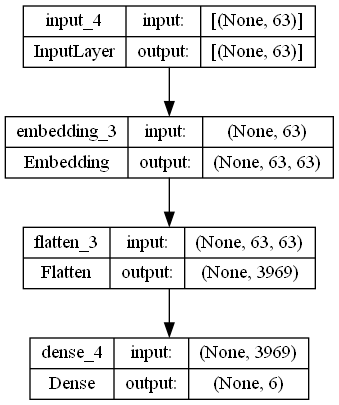

In [111]:
# plot model
tf.keras.utils.plot_model(model_embed, show_shapes=True, show_layer_names=True)

In [105]:
# # Compile the model
# model_embed.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['categorical_accuracy'])

In [114]:
# Compile the model
model_embed.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['binary_accuracy'])

In [115]:
checkpoint_callback_embed = ModelCheckpoint('precursor_charge_prediction_model_embed/embed.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Define early stopping
early_stopping_embed = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [51]:
# sanity check for loss
np.log2(6)

2.584962500721156

In [116]:
# Train the model
# X_train, X_test, y_train, y_test
history_embed = model_embed.fit(train_ds_embed, train_labels_embed, epochs=30, batch_size=4096, validation_data=(val_ds_embed, val_labels_embed), callbacks=[checkpoint_callback_embed, early_stopping_embed, WandbCallback()]) #WandbCallback()

Epoch 1/30
145/147 [============================>.] - ETA: 0s - loss: 0.4929 - binary_accuracy: 0.8498WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best)... Done. 0.0s


147/147 [==============================] - 7s 44ms/step - loss: 0.4918 - binary_accuracy: 0.8499 - val_loss: 0.3492 - val_binary_accuracy: 0.8647
Epoch 2/30
145/147 [============================>.] - ETA: 0s - loss: 0.3144 - binary_accuracy: 0.8688WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best)... Done. 0.0s


147/147 [==============================] - 7s 46ms/step - loss: 0.3143 - binary_accuracy: 0.8688 - val_loss: 0.2963 - val_binary_accuracy: 0.8709
Epoch 3/30
145/147 [============================>.] - ETA: 0s - loss: 0.2884 - binary_accuracy: 0.8713WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best)... Done. 0.0s


147/147 [==============================] - 6s 41ms/step - loss: 0.2884 - binary_accuracy: 0.8713 - val_loss: 0.2822 - val_binary_accuracy: 0.8710
Epoch 4/30
145/147 [============================>.] - ETA: 0s - loss: 0.2773 - binary_accuracy: 0.8715WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best)... Done. 0.0s


147/147 [==============================] - 6s 42ms/step - loss: 0.2773 - binary_accuracy: 0.8714 - val_loss: 0.2732 - val_binary_accuracy: 0.8715
Epoch 5/30
145/147 [============================>.] - ETA: 0s - loss: 0.2691 - binary_accuracy: 0.8724WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best)... Done. 0.0s


147/147 [==============================] - 6s 41ms/step - loss: 0.2691 - binary_accuracy: 0.8725 - val_loss: 0.2654 - val_binary_accuracy: 0.8731
Epoch 6/30
145/147 [============================>.] - ETA: 0s - loss: 0.2615 - binary_accuracy: 0.8746WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best)... Done. 0.0s


147/147 [==============================] - 6s 43ms/step - loss: 0.2615 - binary_accuracy: 0.8747 - val_loss: 0.2578 - val_binary_accuracy: 0.8763
Epoch 7/30
145/147 [============================>.] - ETA: 0s - loss: 0.2544 - binary_accuracy: 0.8779WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best)... Done. 0.0s


147/147 [==============================] - 6s 40ms/step - loss: 0.2544 - binary_accuracy: 0.8779 - val_loss: 0.2510 - val_binary_accuracy: 0.8802
Epoch 8/30
145/147 [============================>.] - ETA: 0s - loss: 0.2482 - binary_accuracy: 0.8816WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best)... Done. 0.0s


147/147 [==============================] - 6s 41ms/step - loss: 0.2482 - binary_accuracy: 0.8816 - val_loss: 0.2452 - val_binary_accuracy: 0.8829
Epoch 9/30
145/147 [============================>.] - ETA: 0s - loss: 0.2430 - binary_accuracy: 0.8845WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best)... Done. 0.0s


147/147 [==============================] - 6s 43ms/step - loss: 0.2430 - binary_accuracy: 0.8845 - val_loss: 0.2405 - val_binary_accuracy: 0.8857
Epoch 10/30
145/147 [============================>.] - ETA: 0s - loss: 0.2388 - binary_accuracy: 0.8866WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best)... Done. 0.0s


147/147 [==============================] - 6s 42ms/step - loss: 0.2388 - binary_accuracy: 0.8866 - val_loss: 0.2366 - val_binary_accuracy: 0.8873
Epoch 11/30
145/147 [============================>.] - ETA: 0s - loss: 0.2353 - binary_accuracy: 0.8883WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best)... Done. 0.0s


147/147 [==============================] - 12s 82ms/step - loss: 0.2353 - binary_accuracy: 0.8883 - val_loss: 0.2334 - val_binary_accuracy: 0.8893
Epoch 12/30
145/147 [============================>.] - ETA: 0s - loss: 0.2324 - binary_accuracy: 0.8897WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best)... Done. 0.0s


147/147 [==============================] - 7s 45ms/step - loss: 0.2324 - binary_accuracy: 0.8897 - val_loss: 0.2307 - val_binary_accuracy: 0.8904
Epoch 13/30
146/147 [============================>.] - ETA: 0s - loss: 0.2298 - binary_accuracy: 0.8907WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best)... Done. 0.0s


147/147 [==============================] - 8s 51ms/step - loss: 0.2298 - binary_accuracy: 0.8907 - val_loss: 0.2283 - val_binary_accuracy: 0.8917
Epoch 14/30
145/147 [============================>.] - ETA: 0s - loss: 0.2276 - binary_accuracy: 0.8915WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best)... Done. 0.0s


147/147 [==============================] - 7s 51ms/step - loss: 0.2276 - binary_accuracy: 0.8915 - val_loss: 0.2262 - val_binary_accuracy: 0.8919
Epoch 15/30
146/147 [============================>.] - ETA: 0s - loss: 0.2256 - binary_accuracy: 0.8921WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best)... Done. 0.0s


147/147 [==============================] - 7s 49ms/step - loss: 0.2256 - binary_accuracy: 0.8921 - val_loss: 0.2243 - val_binary_accuracy: 0.8923
Epoch 16/30
146/147 [============================>.] - ETA: 0s - loss: 0.2238 - binary_accuracy: 0.8926WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best)... Done. 0.0s


147/147 [==============================] - 8s 55ms/step - loss: 0.2238 - binary_accuracy: 0.8926 - val_loss: 0.2226 - val_binary_accuracy: 0.8931
Epoch 17/30
146/147 [============================>.] - ETA: 0s - loss: 0.2222 - binary_accuracy: 0.8934WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best)... Done. 0.0s


147/147 [==============================] - 8s 51ms/step - loss: 0.2222 - binary_accuracy: 0.8934 - val_loss: 0.2212 - val_binary_accuracy: 0.8945
Epoch 18/30
145/147 [============================>.] - ETA: 0s - loss: 0.2208 - binary_accuracy: 0.8942WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best)... Done. 0.0s


147/147 [==============================] - 7s 50ms/step - loss: 0.2208 - binary_accuracy: 0.8942 - val_loss: 0.2199 - val_binary_accuracy: 0.8948
Epoch 19/30
145/147 [============================>.] - ETA: 0s - loss: 0.2196 - binary_accuracy: 0.8953WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best)... Done. 0.0s


147/147 [==============================] - 8s 52ms/step - loss: 0.2196 - binary_accuracy: 0.8953 - val_loss: 0.2188 - val_binary_accuracy: 0.8956
Epoch 20/30
146/147 [============================>.] - ETA: 0s - loss: 0.2186 - binary_accuracy: 0.8959WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best)... Done. 0.0s


147/147 [==============================] - 7s 50ms/step - loss: 0.2185 - binary_accuracy: 0.8959 - val_loss: 0.2178 - val_binary_accuracy: 0.8961
Epoch 21/30
145/147 [============================>.] - ETA: 0s - loss: 0.2177 - binary_accuracy: 0.8964WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best)... Done. 0.0s


147/147 [==============================] - 7s 48ms/step - loss: 0.2176 - binary_accuracy: 0.8965 - val_loss: 0.2170 - val_binary_accuracy: 0.8962
Epoch 22/30
145/147 [============================>.] - ETA: 0s - loss: 0.2168 - binary_accuracy: 0.8968WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best)... Done. 0.0s


147/147 [==============================] - 7s 48ms/step - loss: 0.2168 - binary_accuracy: 0.8968 - val_loss: 0.2163 - val_binary_accuracy: 0.8968
Epoch 23/30
146/147 [============================>.] - ETA: 0s - loss: 0.2162 - binary_accuracy: 0.8972WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best)... Done. 0.0s


147/147 [==============================] - 7s 50ms/step - loss: 0.2162 - binary_accuracy: 0.8972 - val_loss: 0.2157 - val_binary_accuracy: 0.8975
Epoch 24/30
146/147 [============================>.] - ETA: 0s - loss: 0.2156 - binary_accuracy: 0.8974WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best)... Done. 0.0s


147/147 [==============================] - 8s 53ms/step - loss: 0.2156 - binary_accuracy: 0.8974 - val_loss: 0.2151 - val_binary_accuracy: 0.8974
Epoch 25/30
145/147 [============================>.] - ETA: 0s - loss: 0.2150 - binary_accuracy: 0.8977WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best)... Done. 0.0s


147/147 [==============================] - 9s 60ms/step - loss: 0.2150 - binary_accuracy: 0.8977 - val_loss: 0.2147 - val_binary_accuracy: 0.8985
Epoch 26/30
145/147 [============================>.] - ETA: 0s - loss: 0.2146 - binary_accuracy: 0.8980WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best)... Done. 0.0s


147/147 [==============================] - 7s 47ms/step - loss: 0.2146 - binary_accuracy: 0.8979 - val_loss: 0.2142 - val_binary_accuracy: 0.8982
Epoch 27/30
145/147 [============================>.] - ETA: 0s - loss: 0.2142 - binary_accuracy: 0.8981WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best)... Done. 0.0s


147/147 [==============================] - 7s 47ms/step - loss: 0.2142 - binary_accuracy: 0.8981 - val_loss: 0.2139 - val_binary_accuracy: 0.8980
Epoch 28/30
146/147 [============================>.] - ETA: 0s - loss: 0.2139 - binary_accuracy: 0.8983WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best)... Done. 0.0s


147/147 [==============================] - 7s 49ms/step - loss: 0.2139 - binary_accuracy: 0.8983 - val_loss: 0.2136 - val_binary_accuracy: 0.8985
Epoch 29/30
145/147 [============================>.] - ETA: 0s - loss: 0.2135 - binary_accuracy: 0.8985WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best)... Done. 0.0s


147/147 [==============================] - 7s 45ms/step - loss: 0.2136 - binary_accuracy: 0.8985 - val_loss: 0.2133 - val_binary_accuracy: 0.8986
Epoch 30/30
145/147 [============================>.] - ETA: 0s - loss: 0.2133 - binary_accuracy: 0.8985WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
INFO:tensorflow:Assets written to: C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best\assets


wandb: Adding directory to artifact (C:\Users\micro\OneDrive\Dokumente\GitHub\Masterpraktikum\wandb\run-20230905_124045-103h26al\files\model-best)... Done. 0.0s


147/147 [==============================] - 6s 44ms/step - loss: 0.2133 - binary_accuracy: 0.8985 - val_loss: 0.2131 - val_binary_accuracy: 0.8991


In [117]:
import datetime
date = datetime.datetime.now().strftime("%m%d%Y")
print(date)

09052023


In [ ]:
# https://cpcscientific.com/esi-ms-peptide-interpretation-guide/
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5588090/
# https://pubs.acs.org/doi/10.1021/acs.analchem.7b01899
# https://www.researchgate.net/publication/8143943_Amino_Acid_Cluster_Formation_Studied_by_Electrospray_Ionization_Mass_Spectrometry
# https://pubs.acs.org/doi/epdf/10.1021/ac990976y
# https://analyticalsciencejournals.onlinelibrary.wiley.com/doi/epdf/10.1002/jms.4348?saml_referrer

In [118]:
model_embed.save(f'precursor_charge_prediction_model_embed/history_embed_150epoch_{date}.h5')

In [119]:
# Access the loss, validation loss, and accuracy from the history object
loss = history_embed.history['loss']
val_loss = history_embed.history['val_loss']
accuracy = history_embed.history['categorical_accuracy']
val_accuracy = history_embed.history['val_categorical_accuracy']

# Plot the loss, validation loss, and accuracy curves
epochs = range(1, len(loss) + 1)

# Create subplots
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot loss and validation loss
ax1.plot(epochs, loss, 'b', label='Training Loss')
ax1.plot(epochs, val_loss, 'r', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot accuracy and validation accuracy
ax2.plot(epochs, accuracy, 'b', label='Training Accuracy')
ax2.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

KeyError: 'categorical_accuracy'

# Inference

In [121]:
import keras
# load model TODO manually switch on/off
model_embed = keras.models.load_model('precursor_charge_prediction_model_embed/history_embed_150epoch_09052023.h5')

In [122]:
def decode_one_hot(one_hot, charges = [1,2,3,4,5,6]):
    for index, hot in enumerate(one_hot):
        if hot == 1:
            return charges[index]

In [123]:
def predictions_no_hot(one_hot, charges = [1,2,3,4,5,6]):
    if one_hot is not None:
        index = np.argmax(one_hot)
        return charges[index]
    else:
        return 'None'

In [124]:
np.argmax([0, 0 ,0 ,0, 1])

4

In [125]:
def get_topK(label_dict, k=1):
    allowed_keys = list()
    sorted_values = sorted(label_dict.values(), reverse=True)
    for i in sorted_values:
        for key, value in label_dict.items():
            if i == value and len(allowed_keys) <= k:
                #allowed_keys.append((key, value))
                allowed_keys.append(key)
    return allowed_keys

In [126]:
import pandas as pd
predict_df = pd.DataFrame(columns=['modified_sequence_vector', 'true_label', 'pred_label', 'prediction', 'modified_sequence', 'seq_length', 'normalized', 'topK'])
# every row of tensor to list
predict_df['modified_sequence_vector'] = test_ds_embed.tolist()
predict_df['true_label'] = test_labels_embed.tolist()
predict_df['pred_label'] = None
predict_df['prediction'] = None
predict_df['true_label'] = predict_df['true_label'].apply(decode_one_hot)
predict_df['modified_sequence'] = test_ds_embed_raw
predict_df['normalized'] = test_true_labels_normalized
predict_df['topK'] = predict_df['normalized'].apply(get_topK)
# write length of modified sequence after seq_translator to 'seq_length'
predict_df['seq_length'] = predict_df['modified_sequence'].apply(lambda x: len(list(seq_translator(x, no_padding=True))))


In [85]:
predict_df.head(4)

,modified_sequence_vector,true_label,pred_label,prediction,modified_sequence,seq_length,normalized,topK
0,"[4, 18, 1, 1, 1, 15, 1, 1, 4, 17, 4, 0, 0, 0, ...",2,None,None,EVAAARAAETE,11,{2: 2308078.0},[2]
1,"[16, 12, 16, 10, 15, 10, 16, 10, 8, 6, 3, 15, ...",2,None,None,SNSLRLSLIGDR,12,"{3: 15888960.0, 2: 41187530.0}","[2, 3]"
2,"[4, 22, 10, 17, 15, 1, 8, 9, 17, 14, 10, 18, 1...",3,None,None,EM[UNIMOD:35]LTRAIKTQLVLLT,15,"{3: 48770720.0, 2: 7114500.0}","[3, 2]"
3,"[8, 13, 15, 18, 17, 17, 13, 10, 16, 16, 10, 0,...",2,None,None,IPRVTTPLSSL,11,{2: 9628667.0},[2]


In [127]:
predict_df['topK'].head(4)

0       [2]
1    [2, 3]
2    [3, 2]
3       [2]
Name: topK, dtype: object

In [128]:
# test predict for one
for index, row in predict_df.iterrows():
    solut1 = np.expand_dims(tf.convert_to_tensor(np.array(predict_df.at[index, "modified_sequence_vector"])), axis=0)
    print(solut1)
    test_give = model_embed.predict(solut1, verbose=False)
    break
print(test_give[0])

[[ 4 18  1  1  1 15  1  1  4 17  4  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]
[9.5915444e-02 7.9900467e-01 1.8333426e-01 1.3368127e-03 3.3343455e-05
 3.2605232e-05]


In [129]:
def generate_charge_prediction_text(charge_predictions, input_sequence='AAAVVCCAA'):
    max_charge_index = np.argmax(charge_predictions)
    max_charge_value = round(charge_predictions[max_charge_index], 2)

    charge_text = f"The predicted charge state for the input sequence '{input_sequence}' is {max_charge_index+1} [{round(max_charge_value*100,2)}%]."
    percentage_text = "Prediction percentages for all states:\n"

    for index, prediction in enumerate(charge_predictions):
        if index != max_charge_index:
            percentage = round(prediction * 100, 2)
            percentage_text += f"Charge state {index+1}: {percentage}%\n"
        else:
            percentage = round(prediction * 100, 2)
            percentage_text += f"--Charge state {index+1}: {percentage}%\n"

    full_text = charge_text + "\n" + percentage_text
    return full_text

In [130]:
model_embed.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 63)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 63, 63)            1449      
                                                                 
 flatten_3 (Flatten)         (None, 3969)              0         
                                                                 
 dense_4 (Dense)             (None, 6)                 23820     
                                                                 
Total params: 25,269
Trainable params: 25,269
Non-trainable params: 0
_________________________________________________________________


In [131]:
# search modified_sequence of length 60 in predict_df and return row index
predict_df[predict_df['seq_length'] >= 40].index[0]

19501

In [132]:
predict_df.head(4)

,modified_sequence_vector,true_label,pred_label,prediction,modified_sequence,seq_length,normalized,topK
0,"[4, 18, 1, 1, 1, 15, 1, 1, 4, 17, 4, 0, 0, 0, ...",2,None,None,EVAAARAAETE,11,{2: 2308078.0},[2]
1,"[16, 12, 16, 10, 15, 10, 16, 10, 8, 6, 3, 15, ...",2,None,None,SNSLRLSLIGDR,12,"{3: 15888960.0, 2: 41187530.0}","[2, 3]"
2,"[4, 22, 10, 17, 15, 1, 8, 9, 17, 14, 10, 18, 1...",3,None,None,EM[UNIMOD:35]LTRAIKTQLVLLT,15,"{3: 48770720.0, 2: 7114500.0}","[3, 2]"
3,"[8, 13, 15, 18, 17, 17, 13, 10, 16, 16, 10, 0,...",2,None,None,IPRVTTPLSSL,11,{2: 9628667.0},[2]




---- new plot: ----
EM[UNIMOD:35]LTRAIKTQLVLLT


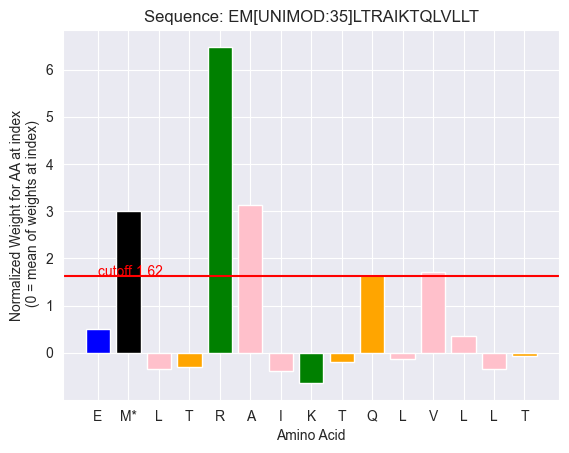

Sequence:  EM[UNIMOD:35]LTRAIKTQLVLLT
Diagram-Algorithm-Prediction:  4
True labels are  dict_keys([3, 2])
Embedding-Layer Prediction-Weights:
   charge state 1:  0.0 False
   charge state 2:  0.58 -> True
   charge state 3:  0.6 -> True
   charge state 4:  0.06 False
   charge state 5:  0.0 False
   charge state 6:  0.0 False
-> False: True labels are  dict_keys([3, 2]) , DA-Prediction:  4  is False
Model-Prediction:  [0.0, 0.58, 0.6, 0.06, 0.0, 0.0]


---- new plot: ----
VTAEADSSSPTGILATSESKHVSTSSDEGSPSASTPMINK


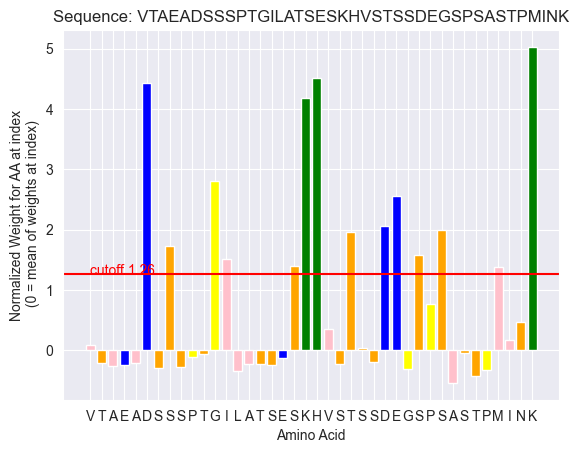

Sequence:  VTAEADSSSPTGILATSESKHVSTSSDEGSPSASTPMINK
Diagram-Algorithm-Prediction:  10
True labels are  dict_keys([6])
Embedding-Layer Prediction-Weights:
   charge state 1:  0.11 False
   charge state 2:  0.04 False
   charge state 3:  0.29 False
   charge state 4:  0.28 False
   charge state 5:  0.1 False
   charge state 6:  0.15 -> True
-> False: True labels are  dict_keys([6]) , DA-Prediction:  10  is False
Model-Prediction:  [0.11, 0.04, 0.29, 0.28, 0.1, 0.15]


---- new plot: ----
IPRVTTPLSSL


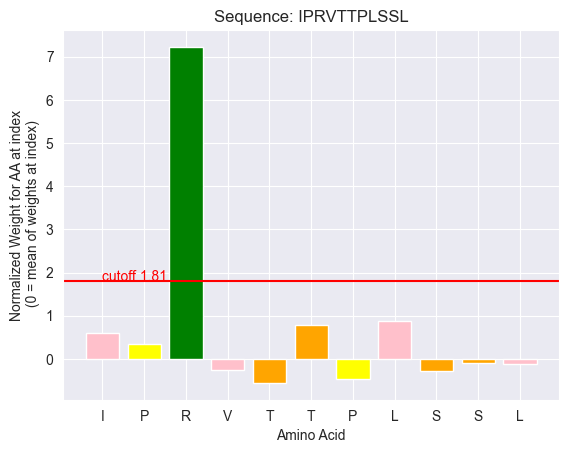

Sequence:  IPRVTTPLSSL
Diagram-Algorithm-Prediction:  1
True labels are  dict_keys([2])
Embedding-Layer Prediction-Weights:
   charge state 1:  0.05 False
   charge state 2:  0.76 -> True
   charge state 3:  0.21 False
   charge state 4:  0.0 False
   charge state 5:  0.0 False
   charge state 6:  0.0 False
-> False: True labels are  dict_keys([2]) , DA-Prediction:  1  is False
Model-Prediction:  [0.05, 0.76, 0.21, 0.0, 0.0, 0.0]


---- new plot: ----
HSVLEVLTAAVEYGLEELR


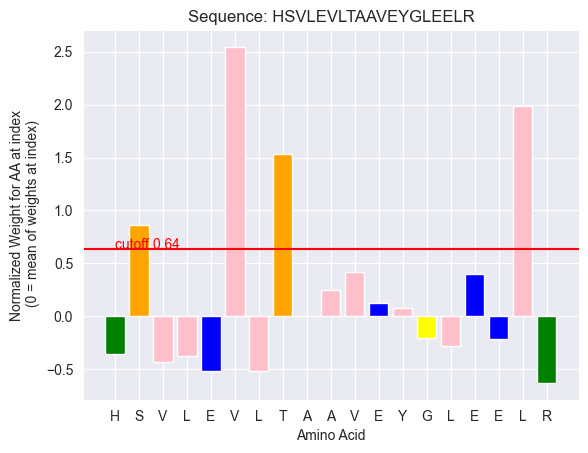

Sequence:  HSVLEVLTAAVEYGLEELR
Diagram-Algorithm-Prediction:  4
True labels are  dict_keys([3])
Embedding-Layer Prediction-Weights:
   charge state 1:  0.0 False
   charge state 2:  0.45 False
   charge state 3:  0.32 -> True
   charge state 4:  0.07 False
   charge state 5:  0.0 False
   charge state 6:  0.0 False
-> False: True labels are  dict_keys([3]) , DA-Prediction:  4  is False
Model-Prediction:  [0.0, 0.45, 0.32, 0.07, 0.0, 0.0]


---- new plot: ----
FLGNLDITV


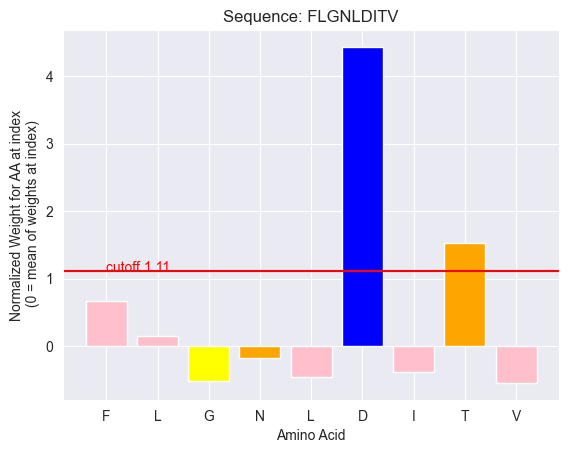

Sequence:  FLGNLDITV
Diagram-Algorithm-Prediction:  2
True labels are  dict_keys([1])
Embedding-Layer Prediction-Weights:
   charge state 1:  0.85 -> True
   charge state 2:  0.92 False
   charge state 3:  0.03 False
   charge state 4:  0.0 False
   charge state 5:  0.0 False
   charge state 6:  0.0 False
-> False: True labels are  dict_keys([1]) , DA-Prediction:  2  is False
Model-Prediction:  [0.85, 0.92, 0.03, 0.0, 0.0, 0.0]


---- new plot: ----
EPEPDVAVL


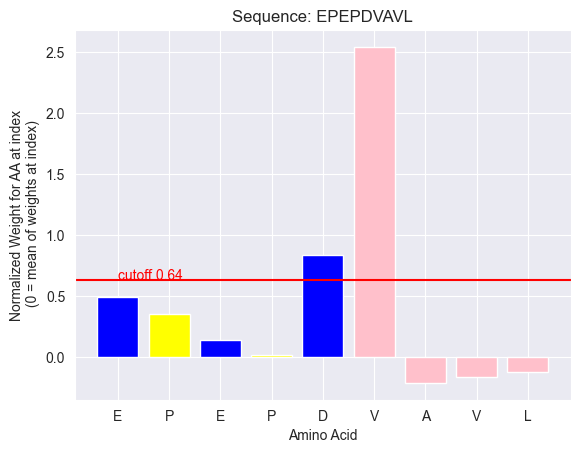

Sequence:  EPEPDVAVL
Diagram-Algorithm-Prediction:  1
True labels are  dict_keys([1])
Embedding-Layer Prediction-Weights:
   charge state 1:  0.82 -> True
   charge state 2:  0.91 False
   charge state 3:  0.04 False
   charge state 4:  0.0 False
   charge state 5:  0.0 False
   charge state 6:  0.0 False
-> True: True labels are  dict_keys([1]) DA-Prediction:  1  is TRUE
Model-Prediction:  [0.82, 0.91, 0.04, 0.0, 0.0, 0.0]


---- new plot: ----
MVTHSKFPAAGM[UNIMOD:35]SR


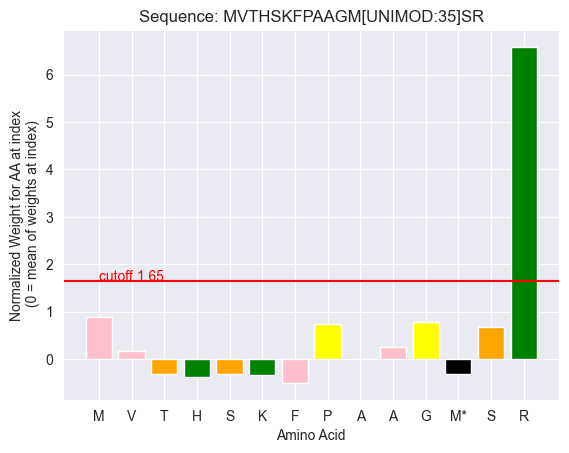

Sequence:  MVTHSKFPAAGM[UNIMOD:35]SR
Diagram-Algorithm-Prediction:  1
True labels are  dict_keys([3, 2, 4])
Embedding-Layer Prediction-Weights:
   charge state 1:  0.0 False
   charge state 2:  0.15 -> True
   charge state 3:  0.63 -> True
   charge state 4:  0.21 -> True
   charge state 5:  0.0 False
   charge state 6:  0.0 False
-> False: True labels are  dict_keys([3, 2, 4]) , DA-Prediction:  1  is False
Model-Prediction:  [0.0, 0.15, 0.63, 0.21, 0.0, 0.0]


 true:  1 false:  6 total:  7


In [133]:
layers = [layer.get_weights() for layer in model_embed.layers]

amino_dict = dict()


sequence_positionen = list(range(63)) # 0,1,2,3,4,5...62
embedding_structure = layers[1][0] # 23 blocks of AA weights


for position in sequence_positionen: # 63 stk
    amino_dict[position] = dict()
    for index, i in enumerate(embedding_structure): #23 stk
        if vocabulary[index] not in amino_dict[position]:
            amino_dict[position][vocabulary[index]] = list()
            amino_dict[position][vocabulary[index]].append(embedding_structure[index][position])
        else:   
            amino_dict[position][vocabulary[index]].append(embedding_structure[index][position])

aminos = list(amino_dict[0])
#print(aminos)
# an welcher position steht die gewichtung an der position 0 für das Amino A



weight_dictionary_per_position = dict()
for i in amino_dict:
    weight_dictionary_per_position[i] = dict()
    weight_position = 0
    sorted_list = [x[0] for x in amino_dict[i].values()]
    sorted_list = sorted(sorted_list, key=float, reverse=False)
    for j in sorted_list:
        for key, value in amino_dict[i].items():
            if j == value[0]:
                #weight_dictionary_per_position[i][key] = weight_position
                #weight_dictionary_per_position[i][key] = weight_position
                average_for_position = np.average([x[0] for x in amino_dict[i].values()]) # normalisation
                weight_dictionary_per_position[i][key] = (j - average_for_position) * (weight_position+1) # highest value = high multiplier
                #print(weight_dictionary_per_position[i][key], key, value[0])
                weight_position += 1
                

#Amino: "A" an index 0 -> [block A für index 0] -> 0.0725 (20/23 Gewichtungsposition -> Farbe (weiss->schwarz): hellgrau)
#test_input_sequence = predict_df['modified_sequence'][51]
total_counter = 0
false_counter = 0
true_counter = 0

for gg in [2, 19501, 3, 4, 5, 6, 7]:
    total_counter+=1
    print("\n")
    print("---- new plot: ----")
    test_input_sequence = predict_df['modified_sequence'][gg]
    test_true_label_input_sequence = predict_df['normalized'][gg]
    print(test_input_sequence)
    #test_input_sequence = 'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' #TODO manually overwrite
    #print(test_input_sequence, len(test_input_sequence))
    test_input_sequence_length = len(re.findall(r'[A-Z]\[[^\]]*\]|.', test_input_sequence))
    #print("len: ", test_input_sequence_length)
    #test_input_sequence += 'X' * (63 - test_input_sequence_length)
    # TODO test_input_sequence += 'X' * (63 - test_input_sequence_length)
    #print(test_input_sequence, len(re.findall(r'[A-Z]\[[^\]]*\]|.', test_input_sequence)))
    test_input_sequence_formatted = re.findall(r'[A-Z]\[[^\]]*\]|.', test_input_sequence)
    #print(test_input_sequence_formatted)
           
    
    
    x_for_plot = list(range(len(test_input_sequence_formatted))) # vocabolary of length 23
    y_for_plot = list()
    # create a list of 0 and 1, 1 if 'X' in test_input_sequence, 0 if not
    #c_for_plot = ['red' if x == 'X' else 'green' for x in test_input_sequence_formatted]
    c_for_plot = []
    
    for index, amino in enumerate(test_input_sequence_formatted):
        if amino in ['R', 'H', 'K']: # Positive
            c_for_plot.append('green')
        elif amino in ['D', 'E']: # Negative
            c_for_plot.append('blue')
        elif amino in ['S', 'T', 'N', 'Q']: # Polar
            c_for_plot.append('orange')
        elif amino in ['A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W']: # Hydrophobic
            c_for_plot.append('pink')
        elif amino in ['G', 'P', 'C']: # Special
            c_for_plot.append('yellow')
        else:
            c_for_plot.append('black')
            
    for index, amino in enumerate(test_input_sequence_formatted):
        y_for_plot.append(weight_dictionary_per_position[index][amino])
        #print(index, amino, ": ", weight_dictionary_per_position[index][amino], "/22")
    
    # for index, amino in enumerate(test_input_sequence_formatted):
    #     if amino == 'X':
    #         c_for_plot.append('red')
    #     voc_list_positive = ['H', 'N', 'R', 'S', 'G', 'T', 'A', 'P', 'M', 'V', 'I', 'L', 'F', 'W', 'K']
    #     if amino in voc_list_positive:
    #         # 14 shades of blue from light to dark:
    #         list_of_colors = ['#e6f2ff', '#cce6ff', '#b3d9ff', '#99ccff', '#80bfff', '#66b3ff', '#4da6ff', '#3399ff', '#1a8cff', '#0080ff', '#0073e6', '#0066cc', '#0059b3', '#004d99']
    #         if amino in ['H', 'R', 'K']: # basic
    #             c_for_plot.append('red')
    #         else:
    #             c_for_plot.append(list_of_colors[voc_list_positive.index(amino)])
    #         #c_for_plot.append('blue')
    #     else:
    #         c_for_plot.append('green')
    # 
    # for index, amino in enumerate(test_input_sequence_formatted):
    #     y_for_plot.append(weight_dictionary_per_position[index][amino])
    #     #print(index, amino, ": ", weight_dictionary_per_position[index][amino], "/22")
    # # colors bars according to c_for_plot
    
    
    ## TODO PREDICTION WITH DIAGRAM
    # give a prediction according to y_for_plot by counting the highest values if at least 1 index away from preivous peak
    peak_height = 0
    peak_counter = 0
    distance_after_last_peak = 1
    minimum_distance = 1
    peak_set = False
    
    for xndex, x in enumerate(y_for_plot):
        #print(xndex,"; ", x, "peak-height: ", peak_height, "distance_after: ", distance_after_last_peak)
        if x > peak_height:
            peak_set = False
            peak_height = x
            distance_after_last_peak+=1
            if xndex == len(y_for_plot)-1 and peak_height > max(y_for_plot)/4:
                peak_counter += 1
                #print("peak found at: ", test_input_sequence_formatted[xndex-1], "peak_counter: ", peak_counter)
    
        elif x < peak_height:
            distance_after_last_peak += 1
            if distance_after_last_peak >= 2 and peak_set == False:
                if peak_height > max(y_for_plot)/4:
                    peak_counter += 1
                peak_height = 0 # reset
                distance_after_last_peak = 1
                peak_set = True
                #print("peak found at: ", test_input_sequence_formatted[xndex-1], "peak_counter: ", peak_counter)        
    
    
    # insert horizontal line at max(y_for_plot)/4 and add label "cutoff"
    plt.axhline(y=max(y_for_plot)/4, color='r', linestyle='-')
    plt.text(0, max(y_for_plot)/4, f'cutoff {round(max(y_for_plot)/4, 2)}', color='red', fontsize=10)

    
    # add title and legend
    plt.title(f"Sequence: {test_input_sequence}")
    plt.xlabel("Amino Acid")
    plt.ylabel("Normalized Weight for AA at index\n (0 = mean of weights at index)")
    plt.xticks(x_for_plot, [x if len(x) == 1 else x[:1]+"*" for x in test_input_sequence_formatted])
    plt.bar(x_for_plot, y_for_plot, color=c_for_plot)
    plt.show()
        
    # TODO prediction
    input_sequence = test_input_sequence
    input_sequence_vector = seq_translator(input_sequence, max_len=63)
    input_sequence_vector = np.expand_dims(tf.convert_to_tensor(np.array(input_sequence_vector)), axis=0)
    test_give = model_embed.predict(input_sequence_vector, verbose=False)
    counter = 1
    #print("-----------------------------")
    print("Sequence: ", input_sequence)
    print("Diagram-Algorithm-Prediction: ", peak_counter)
    print("True labels are ", test_true_label_input_sequence.keys())
    print("Embedding-Layer Prediction-Weights:")
    for x in test_give[0]:
        print(f"   charge state {counter}: ", round(x, 2), end='')
        if counter in test_true_label_input_sequence:
            print(" -> True")
        else:
            print(" False")
        counter += 1
    if peak_counter in test_true_label_input_sequence:
        true_counter+=1
        print("-> True: True labels are ", test_true_label_input_sequence.keys(), "DA-Prediction: ", peak_counter, " is TRUE")
    else: 
        false_counter+=1
        print("-> False: True labels are ", test_true_label_input_sequence.keys(), ", DA-Prediction: ", peak_counter, " is False")
        
    print("Model-Prediction: ", [round(x, 2) for x in model_embed.predict(input_sequence_vector, verbose=False)[0]])
        
print("\n\n true: ", true_counter, "false: ", false_counter, "total: ", total_counter)


In [87]:
layers = [layer.get_weights() for layer in model_embed.layers]

amino_dict = dict()

max_modifier = 4 # todo adjust cutoff max/ max modifier


sequence_positionen = list(range(63)) # 0,1,2,3,4,5...62
embedding_structure = layers[1][0] # 23 blocks of AA weights


for position in sequence_positionen: # 63 stk
    amino_dict[position] = dict()
    for index, i in enumerate(embedding_structure): #23 stk
        if vocabulary[index] not in amino_dict[position]:
            amino_dict[position][vocabulary[index]] = list()
            amino_dict[position][vocabulary[index]].append(embedding_structure[index][position])
        else:   
            amino_dict[position][vocabulary[index]].append(embedding_structure[index][position])

aminos = list(amino_dict[0])
#print(aminos)
# an welcher position steht die gewichtung an der position 0 für das Amino A



weight_dictionary_per_position = dict()
for i in amino_dict:
    weight_dictionary_per_position[i] = dict()
    weight_position = 0
    sorted_list = [x[0] for x in amino_dict[i].values()]
    sorted_list = sorted(sorted_list, key=float, reverse=False)
    for j in sorted_list:
        for key, value in amino_dict[i].items():
            if j == value[0]:
                #weight_dictionary_per_position[i][key] = weight_position
                #weight_dictionary_per_position[i][key] = weight_position
                average_for_position = np.average([x[0] for x in amino_dict[i].values()]) # normalisation
                weight_dictionary_per_position[i][key] = (j - average_for_position) * (weight_position+1) # highest value = high multiplier
                #print(weight_dictionary_per_position[i][key], key, value[0])
                weight_position += 1
                

#Amino: "A" an index 0 -> [block A für index 0] -> 0.0725 (20/23 Gewichtungsposition -> Farbe (weiss->schwarz): hellgrau)
#test_input_sequence = predict_df['modified_sequence'][51]
total_counter = 0
false_counter = 0
true_counter = 0
predict_counter = 0

for gg in range(len(predict_df)):
    total_counter+=1
    #print("\n")
    #print("---- new plot: ----")
    test_input_sequence = predict_df['modified_sequence'][gg]
    test_true_label_input_sequence = predict_df['normalized'][gg]
    #print(test_input_sequence)
    #test_input_sequence = 'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC' #TODO manually overwrite
    #print(test_input_sequence, len(test_input_sequence))
    test_input_sequence_length = len(re.findall(r'[A-Z]\[[^\]]*\]|.', test_input_sequence))
    #print("len: ", test_input_sequence_length)
    # TODO test_input_sequence += 'X' * (63 - test_input_sequence_length)
    #print(test_input_sequence, len(re.findall(r'[A-Z]\[[^\]]*\]|.', test_input_sequence)))
    test_input_sequence_formatted = re.findall(r'[A-Z]\[[^\]]*\]|.', test_input_sequence)
    #print(test_input_sequence_formatted)
           
    
    
    x_for_plot = list(range(len(test_input_sequence_formatted))) # vocabolary of length 23
    y_for_plot = list()
    # create a list of 0 and 1, 1 if 'X' in test_input_sequence, 0 if not
    c_for_plot = ['red' if x == 'X' else 'green' for x in test_input_sequence_formatted]
    for index, amino in enumerate(test_input_sequence_formatted):
        y_for_plot.append(weight_dictionary_per_position[index][amino])
        #print(index, amino, ": ", weight_dictionary_per_position[index][amino], "/22")
    # colors bars according to c_for_plot
    
    ## TODO PREDICTION WITH DIAGRAM
    # give a prediction according to y_for_plot by counting the highest values if at least 1 index away from preivous peak
    peak_height = 0
    peak_counter = 0
    distance_after_last_peak = 1
    minimum_distance = 1
    peak_set = False
    
    
    for xndex, x in enumerate(y_for_plot):
        #print(xndex,"; ", x, "peak-height: ", peak_height, "distance_after: ", distance_after_last_peak)
        if x > peak_height:
            peak_set = False
            peak_height = x
            distance_after_last_peak+=1
            if xndex == len(y_for_plot)-1 and peak_height > max(y_for_plot)/max_modifier:
                peak_counter += 1
                #print("peak found at: ", test_input_sequence_formatted[xndex-1], "peak_counter: ", peak_counter)
    
        elif x < peak_height:
            distance_after_last_peak += 1
            if distance_after_last_peak >= 2 and peak_set == False:
                if peak_height > max(y_for_plot)/max_modifier:
                    peak_counter += 1
                peak_height = 0 # reset
                distance_after_last_peak = 1
                peak_set = True
                #print("peak found at: ", test_input_sequence_formatted[xndex-1], "peak_counter: ", peak_counter)        
    #print("Prediction: ", peak_counter)

        
    # TODO prediction
    input_sequence = test_input_sequence
    input_sequence_vector = seq_translator(input_sequence, max_len=63)
    input_sequence_vector = np.expand_dims(tf.convert_to_tensor(np.array(input_sequence_vector)), axis=0)
    test_give = model_embed.predict(input_sequence_vector, verbose=False)
    counter = 1
    #print("-----------------------------")
    #print("Sequence: ", input_sequence)
    for x in test_give[0]:
        #print(f"charge state {counter}: ", round(x, 2))
        counter += 1
        if x == peak_counter:
            predict_counter += 1
    if peak_counter in test_true_label_input_sequence:
        true_counter+=1
        #print("-> ", test_true_label_input_sequence[peak_counter], "Prediction: ", peak_counter, " is TRUE")
    else: 
        false_counter+=1
        #print("-> prediction wrong: ", test_true_label_input_sequence, " for ", peak_counter, " peaks")
   # if total_counter > 1000:
    #    break
print("true: ", true_counter, "false: ", false_counter, "total: ", total_counter)
print("accuracy: ", true_counter/total_counter)
print("predict_counter: ", predict_counter, "total: ", total_counter, "accuracy: ", predict_counter/total_counter)


KeyboardInterrupt: 

In [121]:
# all weights for embed layer per position
layers = [layer.get_weights() for layer in model_embed.layers]

position_dict = dict()
for i in range(23):
    list_of_positions_for_vocab = layers[1][0][i]
    for index, j in enumerate(list_of_positions_for_vocab):
        print(index, j, vocabulary[i], end="; ")
        if index not in position_dict:
            position_dict[index] = list()
            position_dict[index].append(j)
        else:
            position_dict[index].append(j)
    print("\n")
    #print(i, (layers[1][0][i]))
    
for key, value in position_dict.items():
    print(f"mean pos{key}: ",np.mean(value))

0 -0.029369581 X; 1 0.108266726 X; 2 -0.15950684 X; 3 -0.12829039 X; 4 0.093424864 X; 5 -0.13513383 X; 6 -0.062490612 X; 7 -0.029788679 X; 8 -0.11806967 X; 9 0.07412411 X; 10 0.14824843 X; 11 -0.058266897 X; 12 0.0606332 X; 13 -0.08792853 X; 14 0.09911183 X; 15 0.12909457 X; 16 0.11486253 X; 17 -0.018999051 X; 18 0.10146439 X; 19 -0.06385939 X; 20 0.056140974 X; 21 -0.09332429 X; 22 0.061761253 X; 23 -0.15752359 X; 24 0.027231792 X; 25 -0.07761304 X; 26 0.106759176 X; 27 0.08786734 X; 28 -0.16253833 X; 29 0.08837222 X; 30 -0.053140957 X; 31 0.09794457 X; 32 0.09444322 X; 33 -0.071940325 X; 34 -0.047110748 X; 35 0.08137617 X; 36 -0.16546868 X; 37 -0.09271693 X; 38 0.09702617 X; 39 -0.07870451 X; 40 0.049816016 X; 41 0.08688169 X; 42 -0.10371201 X; 43 0.11794306 X; 44 0.008039187 X; 45 -0.17030068 X; 46 0.043163534 X; 47 0.055657625 X; 48 -0.14146344 X; 49 0.11831282 X; 50 0.16521828 X; 51 0.14717956 X; 52 0.15154935 X; 53 0.14087695 X; 54 0.10841147 X; 55 -0.07486993 X; 56 -0.051546536 

In [70]:
predict_df.head(4)

,modified_sequence_vector,true_label,pred_label,prediction,modified_sequence,seq_length
0,"[4, 18, 1, 1, 1, 15, 1, 1, 4, 17, 4, 0, 0, 0, ...",2,None,NaN,EVAAARAAETE,11
1,"[16, 12, 16, 10, 15, 10, 16, 10, 8, 6, 3, 15, ...",2,None,NaN,SNSLRLSLIGDR,12
2,"[4, 22, 10, 17, 15, 1, 8, 9, 17, 14, 10, 18, 1...",3,None,NaN,EM[UNIMOD:35]LTRAIKTQLVLLT,15
3,"[8, 13, 15, 18, 17, 17, 13, 10, 16, 16, 10, 0,...",2,None,NaN,IPRVTTPLSSL,11


In [122]:
# TODO prediction
#input_sequence = "NGVVIATENKHKSPLYEQHSVH"
input_sequence = "EM[UNIMOD:35]LTRAIKTQLVLLT"
print("Sequence: ", input_sequence)
#input_sequence = "AAAGCNN"
input_sequence_vector = seq_translator(input_sequence, max_len=63)
input_sequence_vector = np.expand_dims(tf.convert_to_tensor(np.array(input_sequence_vector)), axis=0)
print("Sequence_vector: ", input_sequence_vector)
test_give = model_embed.predict(input_sequence_vector, verbose=False)
print("Weights_per_Charge_State: ",[round(x, 2) for x in test_give[0]], "Sum: " ,sum([round(x, 2) for x in test_give[0]]))
counter = 1
#print("-----------------------------")
# print("Sequence: ", input_sequence)
# for x in test_give[0]:
#     print(f"charge state {counter}: ", round(x, 2))
#     counter += 1
print("-----------------------------")
print(generate_charge_prediction_text(test_give[0]))

Sequence:  EM[UNIMOD:35]LTRAIKTQLVLLT
Sequence_vector:  [[ 4 22 10 17 15  1  8  9 17 14 10 18 10 10 17  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]
Weights_per_Charge_State:  [0.0, 0.32, 0.66, 0.02, 0.0, 0.0] Sum:  1.0000000186264515
-----------------------------
The predicted charge state for the input sequence 'AAAVVCCAA' is 3 [66.0%].
Prediction percentages for all states:
Charge state 1: 0.0%
Charge state 2: 32.05%
--Charge state 3: 65.91%
Charge state 4: 2.04%
Charge state 5: 0.0%
Charge state 6: 0.0%


In [188]:
# # PREDICT
# counter_index = 0
# stop_index = 100
# test_run = False # TODO manual switch
# try: 
#     for index, row in predict_df.iterrows():
#         solut = np.expand_dims(tf.convert_to_tensor(np.array(predict_df.at[index, "modified_sequence_vector"])), axis=0)
#         predict_df.at[index, 'prediction'] = model_embed.predict(solut, verbose=False)
#         counter_index += 1
#         if test_run:
#             if counter_index >= stop_index:
#                 break
#     predict_df['pred_label'] = predict_df['prediction'].apply(predictions_no_hot)
# except KeyboardInterrupt:
#     print("KeyboardInterrupt", f"at {counter_index} of {predict_df.shape[0]}")
#     predict_df['pred_label'] = predict_df['prediction'].apply(predictions_no_hot)

In [189]:
predict_df.tail(4)

,modified_sequence_vector,true_label,pred_label,prediction,modified_sequence,seq_length,normalized,topK
83078,"[17, 21, 10, 8, 21, 6, 3, 15, 0, 0, 0, 0, 0, 0...",2,2,"[[0.0040206457, 0.9952087, 0.000769298, 1.4628...",TC[UNIMOD:4]LIC[UNIMOD:4]GDR,8,{2: 35569180.0},[2]
83079,"[9, 7, 6, 18, 16, 19, 17, 13, 4, 4, 18, 4, 4, ...",4,4,"[[3.4637687e-10, 0.010105232, 0.2159436, 0.734...",KHGVSWTPEEVEEARR,16,{4: 92606430.0},[4]
83080,"[20, 18, 8, 4, 16, 16, 16, 7, 17, 13, 4, 10, 1...",3,3,"[[8.8233566e-05, 0.37959668, 0.5992538, 0.0210...",YVIESSSHTPELAR,14,"{2: 7530969.0, 3: 13415830.0}","[3, 2]"
83081,"[12, 18, 16, 3, 1, 18, 1, 14, 16, 17, 15, 0, 0...",2,2,"[[0.041889735, 0.9399164, 0.018157395, 3.64850...",NVSDAVAQSTR,11,"{1: 1124792.0, 2: 5351471.0}","[2, 1]"


In [190]:
predict_df['normalized']

0                        {2: 2308078.0}
1        {3: 15888960.0, 2: 41187530.0}
2         {3: 48770720.0, 2: 7114500.0}
3                        {2: 9628667.0}
4                        {3: 1524013.0}
                      ...              
83077    {4: 26239530.0, 3: 30524360.0}
83078                   {2: 35569180.0}
83079                   {4: 92606430.0}
83080     {2: 7530969.0, 3: 13415830.0}
83081      {1: 1124792.0, 2: 5351471.0}
Name: normalized, Length: 83082, dtype: object

In [90]:
# IMPORTANT for label verification after PREDICT TODO if not called before
#predict_df['pred_label'] = predict_df['prediction'].apply(predictions_no_hot)

In [191]:
predict_df.head(4)

,modified_sequence_vector,true_label,pred_label,prediction,modified_sequence,seq_length,normalized,topK
0,"[4, 18, 1, 1, 1, 15, 1, 1, 4, 17, 4, 0, 0, 0, ...",2,2,"[[0.12747392, 0.8626547, 0.009850538, 2.075463...",EVAAARAAETE,11,{2: 2308078.0},[2]
1,"[16, 12, 16, 10, 15, 10, 16, 10, 8, 6, 3, 15, ...",2,2,"[[0.00020726993, 0.5206397, 0.476445, 0.002706...",SNSLRLSLIGDR,12,"{3: 15888960.0, 2: 41187530.0}","[2, 3]"
2,"[4, 22, 10, 17, 15, 1, 8, 9, 17, 14, 10, 18, 1...",3,3,"[[3.4061266e-06, 0.25153342, 0.7321024, 0.0163...",EM[UNIMOD:35]LTRAIKTQLVLLT,15,"{3: 48770720.0, 2: 7114500.0}","[3, 2]"
3,"[8, 13, 15, 18, 17, 17, 13, 10, 16, 16, 10, 0,...",2,2,"[[0.043792143, 0.93763536, 0.018512432, 6.0023...",IPRVTTPLSSL,11,{2: 9628667.0},[2]


In [192]:
# iterate all rows of grouped_df_embed
size_of_df = predict_df.shape[0]
true_counter = 0
for index, row in predict_df.iterrows():
    if row['true_label'] == row['pred_label']:
        true_counter += 1

print(true_counter/size_of_df, true_counter, size_of_df)

0.7874389157699622 65422 83082


In [193]:
1 / np.log10(6) # TODO sanity check, look into formula

1.2850972089384687

In [123]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import seaborn as sn

true_labels = predict_df['true_label']
predicted_labels = predict_df['pred_label']


cm = confusion_matrix(true_labels, predicted_labels)
print(cm)
print("Accuracy: ", accuracy_score(true_labels, predicted_labels))
# TODO calculate for score for each class (and/or average)
# TODO lookup logic for weighted, macro etc. -> presentation
print("Precision_weighted: ", precision_score(true_labels, predicted_labels, average='weighted'))
print("Recall_weighted: ", recall_score(true_labels, predicted_labels, average='weighted'))
print("F1_weighted: ", f1_score(true_labels, predicted_labels, average='weighted'))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
# add legend title and axis labels
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
# plt.colorbar(label="Number of Samples")
plt.show()


#sn.heatmap(cm2, annot=True, cmap="crest")
# TODO  check if most abundant is chosen

ValueError: Classification metrics can't handle a mix of multiclass and unknown targets

In [124]:
# TopK-Metrics
# iterate over all rows in predict_df and compare true_label with topK and set column topK_inference to either True or False
predict_df['topK_inference'] = None
for index, row in predict_df.iterrows():
        if row['pred_label'] is None or row['prediction'] is None:
            predict_df.at[index, 'topK_inference'] = None
        elif row['pred_label'] in row['topK']:
            predict_df.at[index, 'topK_inference'] = True
        else:
            predict_df.at[index, 'topK_inference'] = False
            #print(row['prediction'], row['pred_label'], row['topK'])


In [125]:
# calculate accuracy for topK_inference
topK_true = predict_df['topK_inference'].value_counts()[True] 
topK_false = predict_df['topK_inference'].value_counts()[False]
topK_total = topK_true + topK_false
print("Correct: ", topK_true, "Wrong: ", topK_false, "Total: ",topK_total)

topK_accuracy = predict_df['topK_inference'].value_counts()[True] / (predict_df['topK_inference'].value_counts()[True] + predict_df['topK_inference'].value_counts()[False])
print("TopK-Accuracy: ", topK_accuracy)

KeyError: True

In [126]:
predict_df.head(4)

,modified_sequence_vector,true_label,pred_label,prediction,modified_sequence,seq_length,normalized,topK,topK_inference
0,"[4, 18, 1, 1, 1, 15, 1, 1, 4, 17, 4, 0, 0, 0, ...",2,None,None,EVAAARAAETE,11,{2: 2308078.0},[2],None
1,"[16, 12, 16, 10, 15, 10, 16, 10, 8, 6, 3, 15, ...",2,None,None,SNSLRLSLIGDR,12,"{3: 15888960.0, 2: 41187530.0}","[2, 3]",None
2,"[4, 22, 10, 17, 15, 1, 8, 9, 17, 14, 10, 18, 1...",3,None,None,EM[UNIMOD:35]LTRAIKTQLVLLT,15,"{3: 48770720.0, 2: 7114500.0}","[3, 2]",None
3,"[8, 13, 15, 18, 17, 17, 13, 10, 16, 16, 10, 0,...",2,None,None,IPRVTTPLSSL,11,{2: 9628667.0},[2],None


# Error for each class due to sequence length

In [127]:
# calculate error for each class corresponding to sequence length, TODO normalize for sequence length occurence
seq_len_dict = dict()
seq_len_correct = dict()
for index, length in predict_df['seq_length'].items():
    if length in seq_len_dict:
        seq_len_dict[length] += 1
        if predict_df.at[index, 'true_label'] == predict_df.at[index, 'pred_label']:
            seq_len_correct[length] += 1
    else:
        seq_len_dict[length] = 1
        if predict_df.at[index, 'true_label'] == predict_df.at[index, 'pred_label']:
            seq_len_correct[length] = 1
        else:
            seq_len_correct[length] = 0

print(len(seq_len_dict), sum(seq_len_dict.values()))
print(seq_len_dict[11])
print(seq_len_correct[11])

35 83082
7890
0


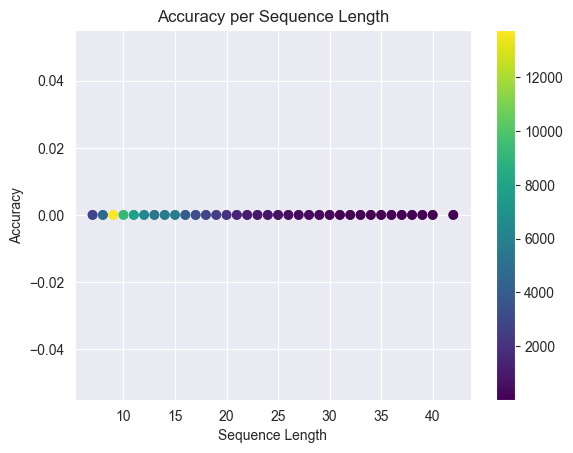

In [128]:
correct_matches = dict()
for key, value in seq_len_dict.items():
    correct_matches[key] = seq_len_correct[key] / value
# plot in pyplot seq_len_dict vs seq_len_correct
import matplotlib.pyplot as plt

plt.xlabel('Sequence Length')
plt.ylabel('Accuracy')
#label for color
plt.title('Accuracy per Sequence Length')


plt.colorbar(plt.scatter(list(seq_len_dict.keys()), list(correct_matches.values()), c=list(seq_len_dict.values()), cmap='viridis', label="all"))
plt.scatter(list(seq_len_dict.keys()), list(correct_matches.values()), c=list(seq_len_dict.values()), cmap='viridis', label="all")

# TOPK: Error for each class due to sequence length

In [205]:
predict_df.tail(4)

,modified_sequence_vector,true_label,pred_label,prediction,modified_sequence,seq_length,normalized,topK,topK_inference
83078,"[17, 21, 10, 8, 21, 6, 3, 15, 0, 0, 0, 0, 0, 0...",2,2,"[[0.0040206457, 0.9952087, 0.000769298, 1.4628...",TC[UNIMOD:4]LIC[UNIMOD:4]GDR,8,{2: 35569180.0},[2],True
83079,"[9, 7, 6, 18, 16, 19, 17, 13, 4, 4, 18, 4, 4, ...",4,4,"[[3.4637687e-10, 0.010105232, 0.2159436, 0.734...",KHGVSWTPEEVEEARR,16,{4: 92606430.0},[4],True
83080,"[20, 18, 8, 4, 16, 16, 16, 7, 17, 13, 4, 10, 1...",3,3,"[[8.8233566e-05, 0.37959668, 0.5992538, 0.0210...",YVIESSSHTPELAR,14,"{2: 7530969.0, 3: 13415830.0}","[3, 2]",True
83081,"[12, 18, 16, 3, 1, 18, 1, 14, 16, 17, 15, 0, 0...",2,2,"[[0.041889735, 0.9399164, 0.018157395, 3.64850...",NVSDAVAQSTR,11,"{1: 1124792.0, 2: 5351471.0}","[2, 1]",True


In [206]:
# calculate error for each class corresponding to sequence length, TODO normalize for sequence length occurence
seq_len_dict = dict()
seq_len_correct = dict()
for index, length in predict_df['seq_length'].items():
    if length in seq_len_dict:
        seq_len_dict[length] += 1
        if predict_df.at[index, 'topK_inference']:
            seq_len_correct[length] += 1
    else:
        seq_len_dict[length] = 1
        if predict_df.at[index, 'topK_inference']:
            
            seq_len_correct[length] = 1
        else:
            seq_len_correct[length] = 0
print(len(seq_len_dict), sum(seq_len_dict.values()))
print(seq_len_dict[11])
print(seq_len_correct[11])

35 83082
7890
7652


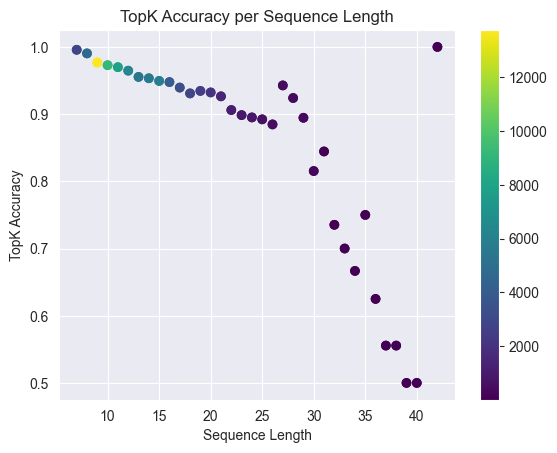

In [207]:
correct_matches = dict()
for key, value in seq_len_dict.items():
    correct_matches[key] = seq_len_correct[key] / value
# plot in pyplot seq_len_dict vs seq_len_correct
import matplotlib.pyplot as plt

plt.xlabel('Sequence Length')
plt.ylabel('TopK Accuracy')
#label for color
plt.title('TopK Accuracy per Sequence Length')


plt.colorbar(plt.scatter(list(seq_len_dict.keys()), list(correct_matches.values()), c=list(seq_len_dict.values()), cmap='viridis', label="all"))
plt.scatter(list(seq_len_dict.keys()), list(correct_matches.values()), c=list(seq_len_dict.values()), cmap='viridis', label="all")

In [211]:
from sklearn.metrics import confusion_matrix

new_df = pd.DataFrame(columns=['charge','accuracy'])

new_df['charge'] = [1,2,3,4,5,6]
new_df['precision'] = precision_score(true_labels, predicted_labels, average=None)
new_df['recall'] = recall_score(true_labels, predicted_labels, average=None)
new_df['f1'] = f1_score(true_labels, predicted_labels, average=None)


In [209]:
new_df # evaluation metrics per charge state (class)

,charge,accuracy,precision,recall,f1
0,1,0.668686,0.824813,0.668686,0.738589
1,2,0.831385,0.878971,0.831385,0.854516
2,3,0.799808,0.687836,0.799808,0.739608
3,4,0.587729,0.640201,0.587729,0.612844
4,5,0.345515,0.536082,0.345515,0.420202
5,6,0.093407,0.531250,0.093407,0.158879


# Outputs to compare with prosit

In [ ]:
train_df

In [ ]:
train_df = pd.DataFrame(columns=['modified_sequence', 'most_abundant_charge_vector', 'modified_sequence_vector'])
train_df['modified_sequence'] = train_ds_embed_raw
train_df['most_abundant_charge_vector'] = train_labels_embed.numpy().tolist()
train_df['modified_sequence_vector'] = train_ds_embed.numpy().tolist()

val_df = pd.DataFrame(columns=['modified_sequence', 'most_abundant_charge_vector', 'modified_sequence_vector'])
val_df['modified_sequence'] = val_ds_embed_raw
val_df['modified_sequence_vector'] = val_ds_embed.numpy().tolist()
val_df['most_abundant_charge_vector'] = val_labels_embed.numpy().tolist()

test_df = pd.DataFrame(columns=['modified_sequence', 'most_abundant_charge_vector', 'modified_sequence_vector'])
test_df['modified_sequence'] = test_ds_embed_raw
test_df['modified_sequence_vector'] = test_ds_embed.numpy().tolist()
test_df['most_abundant_charge_vector'] = test_labels_embed.numpy().tolist()

In [ ]:
train_df.to_csv('comparison_files/train_df.tsv', sep="\t")
val_df.to_csv('comparison_files/val_df.tsv', sep="\t")
test_df.to_csv('comparison_files/test_df.tsv', sep="\t")

In [ ]:
print(len(train_df), len(val_df), len(test_df))

# KerasTuner

In [347]:
wandb.init(project='precursor_charge_prediction_kerastuner')

categorical_accuracy,▁▇██
epoch,▁▃▆█
loss,█▂▁▁
val_categorical_accuracy,▁█▇█
val_loss,█▃▃▁
best_epoch,3
best_val_loss,0.49986
categorical_accuracy,0.78662
epoch,3
loss,0.49983
val_categorical_accuracy,0.78522


In [348]:
import keras_tuner
from tensorflow import keras
from keras import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Input, concatenate, Rescaling

def build_model(hp):
    model_kerastuner = keras.Sequential([
    Embedding(input_dim=voc_len, output_dim=max_len_seq, input_length=max_len_seq),
    Flatten(),
    Dense(units=hp.Int('dense_1_units', min_value=63, max_value=256, step=16), activation='relu'),
    Dense(num_classes, activation="softmax")  # sigmoid for binary classification
    ])

    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log"),

    model_kerastuner.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["categorical_accuracy"])

    return model_kerastuner


tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    overwrite=True,
    executions_per_trial=3,
    directory='output_tuner', )
tuner.search(train_ds_embed, train_labels_embed, epochs=5, batch_size=4096, validation_data=(val_ds_embed, val_labels_embed), callbacks=[WandbCallback()]) #WandbCallback(
best_model = tuner.get_best_models()[0]
best_model_all = tuner.get_best_models()
#hp.Choice('conv_3_kernel', values=[3, 10]), hp.Int('dense_1_units', min_value=32, max_value=128, step=16), hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

Trial 5 Complete [00h 02m 15s]
val_loss: 0.5195921063423157

Best val_loss So Far: 0.4886218508084615
Total elapsed time: 00h 11m 30s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [351]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 63, 63)            1449      
                                                                 
 flatten (Flatten)           (None, 3969)              0         
                                                                 
 dense (Dense)               (None, 111)               440670    
                                                                 
 dense_1 (Dense)             (None, 6)                 672       
                                                                 
Total params: 442,791
Trainable params: 442,791
Non-trainable params: 0
_________________________________________________________________


# IGNORE FROM HERE

## Check in with Franzi's group for reporting

### Multilable Model
#### WIP in precursor_charge_predictor

## Model Testing
### check if models only predict charge 2 or also other charges. Due to 'overrepresentation' the best bet for the model could be to only output charge state 2

## Hyperparameter Tuning

# Inference

In [122]:
batches_parquet[file_list[1]]["precursor_charge"].value_counts()

2    1401912
3     787278
4     220159
5      34381
1      26371
6       4417
Name: precursor_charge, dtype: int64

In [123]:
last_model = keras.models.load_model('precursor_charge_prediction_model_embed/history_embed_150epoch_08102023.h5')

In [124]:
#layers = [layer.get_weights() for layer in last_model.layers]

In [125]:
batches_parquet.keys()

dict_keys(['data/Thermo_SRM_Pool_meta_data.parquet', 'data/TUM_aspn_meta_data.parquet', 'data/TUM_first_pool_meta_data.parquet', 'data/TUM_HLA2_meta_data.parquet', 'data/TUM_HLA_meta_data.parquet', 'data/TUM_isoform_meta_data.parquet', 'data/TUM_lysn_meta_data.parquet', 'data/TUM_missing_first_meta_data.parquet', 'data/TUM_proteo_TMT_meta_data.parquet', 'data/TUM_second_addon_meta_data.parquet', 'data/TUM_second_pool_meta_data.parquet', 'data/TUM_third_pool_meta_data.parquet'])

In [126]:
# Make validation data
inference_df = batches_parquet[file_list[1]][["precursor_charge", "modified_sequence_vector", "precursor_intensity"]].copy()

KeyError: "['modified_sequence_vector'] not in index"

In [ ]:
inference_df.head(4)

In [ ]:
[len(i) for i in inference_df["modified_sequence_vector"] if len(i) != 50]

In [ ]:
inference_df = inference_df[inference_df['modified_sequence_vector'].apply(lambda x: len(x) <= 50)]

In [ ]:
[len(i) for i in inference_df["modified_sequence_vector"] if len(i) != 50]

In [ ]:
[i for i in inference_df["precursor_charge"] if i not in [2,3,4]]

In [ ]:
[i for i in inference_df["precursor_intensity"] if i > 1000000000000]

In [ ]:
inference_df

In [ ]:
inference_df[list(range(0, 50))] = pd.DataFrame(inference_df["modified_sequence_vector"].tolist(), index= inference_df.index)

In [ ]:
inference_df.drop("modified_sequence_vector", axis=1, inplace=True)

In [ ]:
inference_df.head(4)

In [ ]:
inference_ds = tf.convert_to_tensor(inference_df)

In [ ]:
inference_target = inference_ds[:, 0]
inference_features = inference_ds[:, 1:]

In [ ]:
inference_target_labels =  np.array([one_hot_precursor(i, charges=charge_ranges) for i in inference_target])

In [ ]:
results = model_cce.evaluate(inference_features, inference_target_labels, batch_size=256)
print("test loss, test acc:", results)

## Evaluate the models
- confusion matrix
- accuracy
- loss

Confusion Matrix

In [ ]:
import sklearn
matrix = sklearn.metrics.confusion_matrix(train_ds_labels.argmax(axis=1), inference_target_labels.argmax(axis=1))

In [ ]:
#!pip install scikit-learn
#!pip install numpy --upgrade
#!pip install pandas --upgrade
#!pip install matplotlib --upgrade
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
#do_predictions = model.predict(test_ds)

y_pred = []
y_true = []

# iterate over the dataset
for index, i in enumerate(inference_ds):   # use dataset.unbatch() with repeat
   print(inference_target_labels[index])
   print(inference_features[index])
   # append true labels
   y_true.append(inference_target_labels[index])
   # compute predictions
   preds = model_cce.predict(inference_features[index])
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = -1))
# convert the true and predicted labels into tensors
true_labels = tf.cast(tf.concat([item for item in y_true], axis = 0), tf.float32)
predicted_labels = tf.cast(tf.concat([item for item in y_pred], axis = 0), tf.float32)


cm = confusion_matrix(true_labels, predicted_labels)
#print(cm)
report = classification_report(true_labels,predicted_labels, target_names=class_names)

report_dict = classification_report(true_labels, predicted_labels, output_dict=True)
#print(report_dict)
print(report)

#pd.DataFrame(report_dict).transpose()


Accuracy/ Sens/ Spec

In [ ]:
import keras.backend as K
def matthews_correlation(y_true, y_pred):
    #print(y_pred.shape, y_true.shape)
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(K.cast(y_pos * y_pred_pos, 'float32'))
    tn = K.sum(K.cast(y_neg * y_pred_neg, 'float32'))
    fp = K.sum(K.cast(y_neg * y_pred_pos, 'float32'))
    fn = K.sum(K.cast(y_pos * y_pred_neg, 'float32'))

    print("OVERALL:")
    print(" Accuracy ", ((tp + tn) / (tp + tn + fp + fn)).numpy())
    print(" Sensitivity ", (tp / (tp + fn)).numpy())
    print(" Specificity ", (tn / (tn + fp)).numpy())

    numerator = (tp * tn - fp * fn)
    #print(tp.numpy(), fp.numpy())
    test = (((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))
    #print(test)
    denominator = K.sqrt(K.cast(test, 'float32'))

    return numerator / (denominator + K.epsilon())


#print(true_labels, predicted_labels)
print(" matthews_correlation(rounded): ", (matthews_correlation(true_labels, predicted_labels).numpy()))

MCC

In [ ]:
from sklearn.metrics import matthews_corrcoef

print("matthews_correlation:", matthews_corrcoef(true_labels, predicted_labels))

Direct eval:

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

eval_prec = Precision()
eval_rec = Recall()
eval_acc = BinaryAccuracy()

In [ ]:
for batch in test_ds.as_numpy_iterator():
    X, y = batch
    y = tf.keras.utils.to_categorical(y, num_classes=13, dtype='int')
    yhat = model.predict(X)
    eval_prec.update_state(y, yhat)
    eval_rec.update_state(y, yhat)
    eval_acc.update_state(y, yhat)

In [ ]:
print(f'Precision: {eval_prec.result().numpy()}, Recall: {eval_rec.result().numpy()}, Accuracy: {eval_acc.result().numpy()}')